In [2]:
import numpy as np, scipy as sp
import time
import scipy.linalg, scipy.sparse.linalg
from flint import fmpq, fmpz, fmpq_mat
from mpmath import mp
from matplotlib import pyplot as p
from importlib import reload

Let $J$ be the random variable with $\mathbb P(J = j) = 1/j(j+1)$.

If we currently have $x$ active sites, then one step works like this:
* the rightmost chip falls asleep with probability $q$.
* the rightmost chip moves left with probability $(1-q)/2$, and then randomly walks until it returns to the origin. This will wake up $J$ sites to the left of the chip, but $x - 1$ were already awake anyway, so the new number of awake sites is $(J+1) \vee x$.
* otherwise, it moves right with probability $(1-q)/2$, and then randomly walks until it returns to the origin. This wakes up $J$ sites to the left of the chip which were asleep at first, so the number of awake sites is $J + x$.


### the behaviour of sums of many J

The characteristic function of $J$ is $$F(\theta) := \mathbb E[e^{i\theta J}] = (e^{-i\theta} - 1) \log(1 - e^{i\theta}) + 1,$$ where we are using the principal branch.

Let $S_N$ be the sum of $N$ independent copies of $J$. Then the characteristic function is
$F(\theta)^N = [1 + (e^{-i\theta} - 1) \log(1 - e^{i\theta})]^N$. It is approximately

$$\exp\left(-i \theta N[-\pi/2 + \log(\theta) + O(\theta \log(\theta))]\right).$$

We want to use this to guess the scaling. It turns out that we can scale $S_N \gets S_N / \lambda$ where we define $\lambda$ implicitly: $\lambda$ is a small positive number with $\lambda \log \lambda = -1/N$.
The characteristic function of $S_N / \lambda$ is of course $F(\lambda \theta)^N$, and that is approximately

$$F(\lambda \theta)^N \approx \exp(-i \lambda \theta N[-\pi/2 + \log \lambda + \log \theta + O(\theta \log \theta))]).$$

Here $\lambda$ is bounded by $1$, so the factors of $\lambda$ don't increase the order of the terms that are hidden by the O-notation. However, $\log \lambda$ slowly goes to $-\infty$.

With this scaling, the main term in the exponent above is $-i\theta (\lambda \log \lambda N) = i \theta$, and the other terms are of order $\lambda N = 1/\log(\lambda)$. Therefore, the limit of the characteristic functions is $e^{i\theta}$, and by the continuity theorem for characteristic functions, we get $S_N / \lambda(N) \to \delta_1$.

Let's investigate it numerically.

In [13]:
# theoretically, we can get samples of j by floor(1/U) where U is uniform on (0, 1]
# this isn't perfect but it's close
def generateJ(shape):
    return np.floor(1/np.random.random(shape)).astype(int)
def generate_sum_of_j(count):
    return np.sum(generateJ(count))

In [56]:
many = 1000000

def generate_histogram():
    samples = []
    count = 1000
    t = time.time()
    print("Generating %d samples of sums of %d independent copies of J" % (count, many))
    for j in range(count):
        samples.append(generate_sum_of_j(many))
        if time.time() > t + 1:
            print("%d generated" % j)
            t += 1
    return samples

# cumulative distribution function
def cdf(samples):
    x = np.log(np.sort(samples))
    y = np.arange(len(samples)) / len(samples)
    x = np.concatenate([[0], x])
    y = np.concatenate([[0], y])
    p.plot(x, y)

def estimator(many):
    # solve scale / log(scale) = many
    scale = many
    for i in range(100):
        scale = many * np.log(scale)
    print(scale / np.log(scale), many)
    return scale

#### Generate the samples

In [57]:
samples = generate_histogram()


Generating 1000 samples of sums of 1000000 independent copies of J
109 generated
218 generated
328 generated
437 generated
546 generated
656 generated
765 generated
875 generated
984 generated


#### Plot the samples

1000000.0 1000000


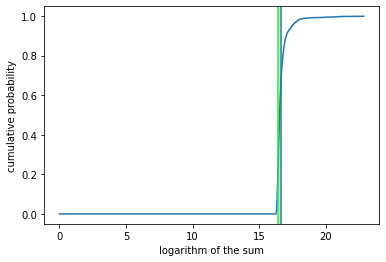

In [58]:
cdf(samples)
p.xlabel("logarithm of the sum")
p.ylabel("cumulative probability")
p.axvline(np.log(estimator(many)), label="estimate")
p.axvline(np.log(many) + np.log(np.log(many)), c=(0, 1, 0))
p.show()

In [27]:
def draw():
    return int(np.floor(1/np.random.random()))

def walk(L, q, start):
    yield start
    while True:
        if np.random.random() < q:
            start -= 1
        else:
            if np.random.random() < 0.5:
                zz = draw()
                start += max(zz - start, 0)
                # whee
            else:
                start += draw()
        if start == 0:
            return start
        if start > L:
            start = L
        yield start

In [66]:
longwalk = list(walk(1000, 0.7, 1000))

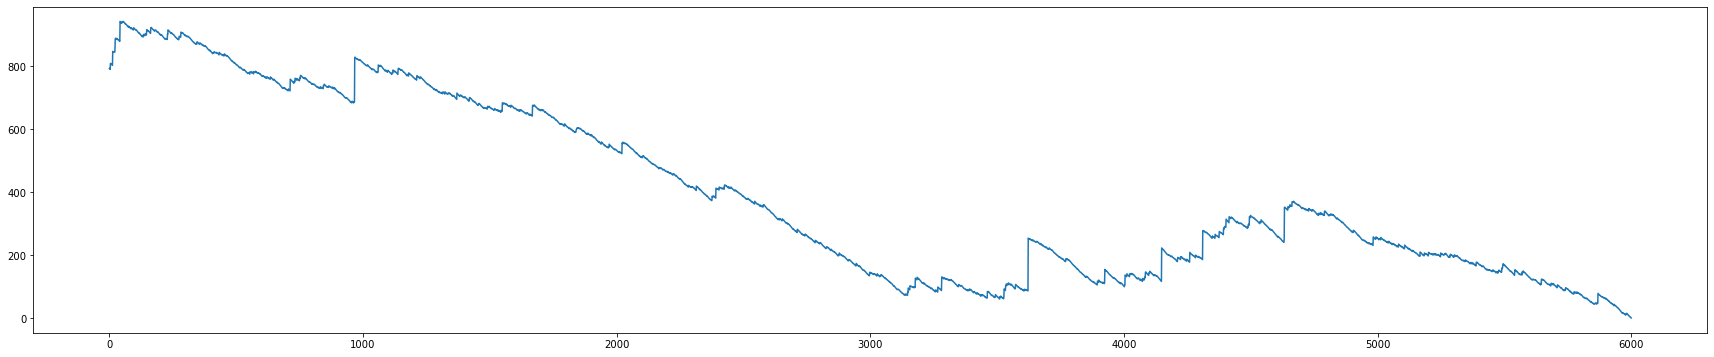

In [67]:
p.figure(figsize=(30, 6))
p.plot(longwalk[-6000:])
p.show()

In [68]:
def bbdraw():
    return int(np.floor(1/np.random.random()))

def bbwalk(L, q, start):
    yield start
    while True:
        if np.random.random() < q:
            start -= 1
        else: start += 1
        if start == 0:
            return start
        if start > L:
            start = L
        yield start

In [77]:
bblong = list(bbwalk(1000, 0.498, 1000))

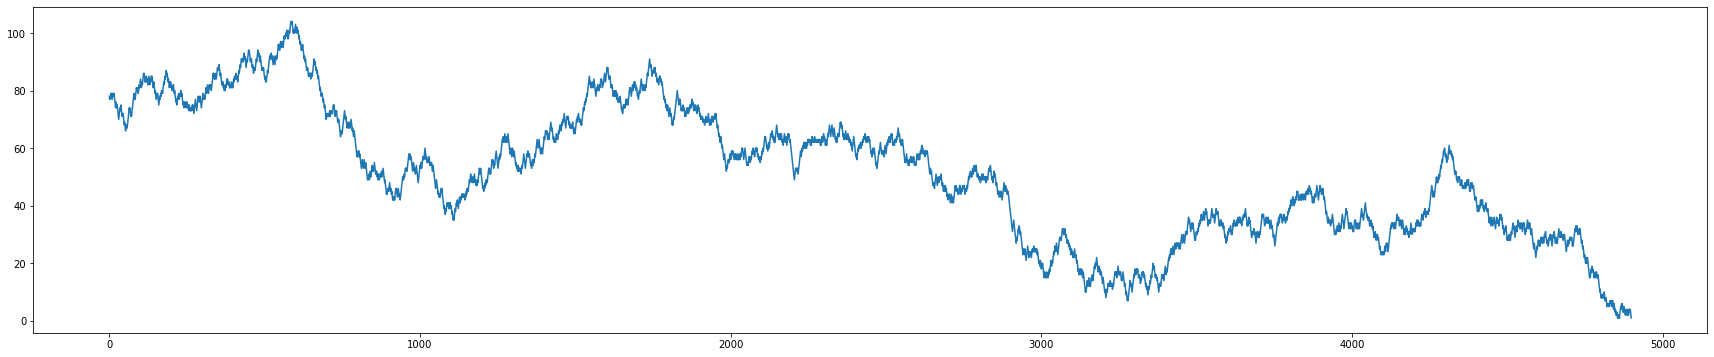

In [135]:
p.figure(figsize=(30, 6))
p.plot(bblong[-4900:])
p.show()

In [224]:
from sympy import *
def FRAC(p, q): return Rational(p, q)

In [665]:
class harmonicwgt:
    def __init__(self, L, q):
        self.values = [0] * (L-1) + [FRAC(1, 1), FRAC(0, 1)]
        self.q = q
        self.L = L
        for j in range(L-2, -1, -1):
            self.values[j] = simplify(self.solvefor(j))
    
    def solvefor(self, j):
        w = self.weight(j)
        if VERBOSE == True:
            print("subtracting")
            for i in range(j + 1, self.L+1):
                print("    %s" % (expand(w[i] * self.values[i])))
                pass
                #print("    (%s) * %s" % (w[i], self.values[i]))
            #print("from %s" % self.values[j+1])
            print("from %s" % expand(self.values[j+1]))
        z = sum(w[i] * self.values[i] for i in range(j+1, self.L+1))
        return (self.values[j+1] - z) / w[j]
    
    def weight(self, j):
        weight = {j: self.q}
        total = FRAC(1, 1)
        for i in range(j+1, self.L+1):
            weight[i] = FRAC(0, 1)
        i = 0
        while True:
            i += 1
            if j + i + 1 == self.L:
                weight[self.L] += (1 - self.q) * FRAC(1, 2*i)
                break
            weight[j + i + 1] += (1 - self.q) * FRAC(1, 2*i*(i+1))
        i = 0
        while True:
            i += 1
            if i == self.L:
                weight[self.L] += (1 - self.q) * FRAC(1, 2*i)
                break
            if i <= j + 1:
                weight[j + 1] += (1 - self.q) * FRAC(1, 2*i*(i+1))
            else:
                weight[i] += (1 - self.q) * FRAC(1, 2*i*(i+1))
        return weight

In [673]:
class harmonicwgt:
    def __init__(self, L, q):
        self.values = [0] * (L-1) + [FRAC(1, 1), FRAC(0, 1)]
        self.harm = [FRAC(1, l*(l+1)) for l in range(1, L+1)]
        self.q = q
        self.L = L
        for j in range(L-2, -1, -1):
            if j%100 == 0:
                print(j)
            self.values[j] = self.solvefor(j)
    
    def solvefor(self, j):
        total = mp.mpf(0)
        for i in range(j+2, self.L+1):
            total += self.values[i] * self.harm[i - j - 2]
        for i in range(j+2, self.L+1):
            total += self.values[i] * self.harm[i - 1]
        total += FRAC(j+1, j+2) * self.values[j+1]
        total *= FRAC(1, 2) * (1 - self.q)
        return (self.values[j+1] - total) / self.q


In [685]:
class fastharmoni:
    def __init__(self, L, q):
        self.q = q
        self.L = L
        self.values = np.array([0.] * (L-1) + [1., 0.])
        self.harm = np.array([1/(l * (l+1)) for l in range(1, L+1)])
        for j in range(L-2, -1, -1):
            if j%100 == 0:
                print(j)
            self.values[j] = self.solvefor(j)
    
    def harmonic_difference_sum(self, a, offset):
        return np.dot(a, self.harm[offset:offset+a.shape[0]]) + a[-1] / (offset+1+a.shape[0])
    
    def solvefor(self, j):
        total = 0
        total += self.harmonic_difference_sum(self.values[j+2:], 0)
        total += (1 - 1/(j+2)) * self.values[j+1]
        total += self.harmonic_difference_sum(self.values[j+2:], j+1)
        total *= (1 - self.q) / 2
        return (self.values[j+1] - total) / self.q


In [714]:
class logmon:
    def __init__(self, L, q):
        self.q = q
        self.L = L
        self.values = np.array([0.] * (L-1) + [0., -np.inf])
        self.harm = np.array([1/(l * (l+1)) for l in range(1, L+1)])
        for j in range(L-2, -1, -1):
            self.values[j] = self.solvefor(j)
    
    def harmonic_difference_sum(self, a, offset):
        assert a[-1] == 0
        return np.dot(a, self.harm[offset:offset+a.shape[0]])

    def solvefor(self, j):
        total = 0
        total += self.harmonic_difference_sum(np.exp(self.values[j+2:] - self.values[j+1]), 0)
        total += (1 - 1/(j+2))
        total += self.harmonic_difference_sum(np.exp(self.values[j+2:] - self.values[j+1]), j+1)
        total *= (1 - self.q) / 2
        return self.values[j+1] + np.log((1 - total) / self.q)

In [721]:
harmonicl = logmon(10000, 0.5).values

In [742]:
1/np.exp(harmonicl[200] - harmonicl[201])

0.8606424945267863

In [691]:
harmonic1, harmonic2 = fastharmoni(1000, 0.5).values, harmonicwgt(1000, 0.5).values

900
800
700
600
500
400
300
200
100
0
900
800
700
600
500
400
300
200
100
0


In [701]:
[mp.log(harmonic2[j]) for j in range(400)]

[mpf('150.79166332723383050936527407345701637637582577869704885877550869'),
 mpf('150.492348342747487812892997938913797600288489671196204292200100468'),
 mpf('150.225718226986845716589999151275632320884355122695117291514802259'),
 mpf('149.978419029923421092477368286661119186518434323927620729944923582'),
 mpf('149.744267094508792923091490562726089042058312247238062581277539002'),
 mpf('149.519793840586128698422227841439818094290409064305754793099678302'),
 mpf('149.302820665472847977338223182966059889856421767699557979343346583'),
 mpf('149.091872488190644190702829915427376266598812945203760472674261141'),
 mpf('148.885895518769346605893374698145775201661501419311483520684267666'),
 mpf('148.684105961993853494799992746219765946772244965759310262072699354'),
 mpf('148.485902218580280799969292277199352260792061201345400579838687868'),
 mpf('148.290810734423433677849654513630094955629972233769307520305270813'),
 mpf('148.098450948162164097059845082785280062691916309929616930378864631'),


In [703]:
harmonic2[:10]

[mpf('307600686249433277942562391103015371688548259266761529430337612160.0'),
 mpf('228032345272460312628258342617574518162568850738354019730581855744.0'),
 mpf('174662819275552097191032305922388236957288260729694135733026998080.0'),
 mpf('136395420568159932058655259005755515827868818620945167302957503680.0'),
 mpf('107921729322253280210654556504960064559042318213228373299102707136.0'),
 mpf('86222656706945703768694315352649114914770863359725468636072289216.0'),
 mpf('69405062174477224264804364028767233165812022990281532235333236128.0'),
 mpf('56205332096767102453105837070573228167393817541607793303765503776.0'),
 mpf('45742811795111197399943354495733101669843431607662156841587797504.0'),
 mpf('37384085907440976023923508724867546966070196807674615835636378400.0')]

In [367]:
def eval(p, q):
    foo = harmonicwgt(60, FRAC(p, q))
    out = np.array(foo.values, dtype=float)
    out = out / out[0]
    return out

In [383]:
with mp.workprec(999):
    harmonic3 = np.array(harmonicwgt(100, FRAC(1, 2)).values, dtype=float)

In [400]:
mp.prec = 53
def FRAC(p, q): return p / q

In [429]:
def time(L, q):
    foo = fastharmoni(L, q)
    #tt = [foo.values[0] - j for j in foo.values]
    #tt = [j / FRAC(p, q) / (tt[-1] - tt[-2]) for j in tt]
    #return sum(tt)
    # atashi iya ne
    #print(foo.values)
    tt = [foo.values[0] - j for j in foo.values]
    tt = [j / q / (foo.values[-2] - foo.values[-1]) for j in tt]
    return sum(tt)

In [447]:
def lotime(L, q):
    foo = logmon(L, q)
    #tt = [foo.values[0] - j for j in foo.values]
    #tt = [j / FRAC(p, q) / (tt[-1] - tt[-2]) for j in tt]
    #return sum(tt)
    # atashi iya ne
    tt = np.log(sum(1 - np.exp(j - foo.values[0]) for j in foo.values))
    tt -= np.log(q)
    tt -= np.log(np.exp(foo.values[-2]) - np.exp(foo.values[-1]))
    tt += foo.values[0]
    return tt

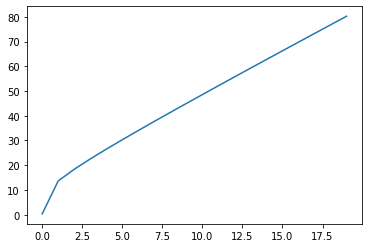

In [499]:
#timings = []
#for j in range(6000, 6100, 100):
#    timings.append(np.array([lotime(j, p/100) for p in range(1, 100)], dtype=float))

plot74 = []
for j in range(20):
    plot74.append(lotime(j * 1000, 0.74))
p.plot(plot74)


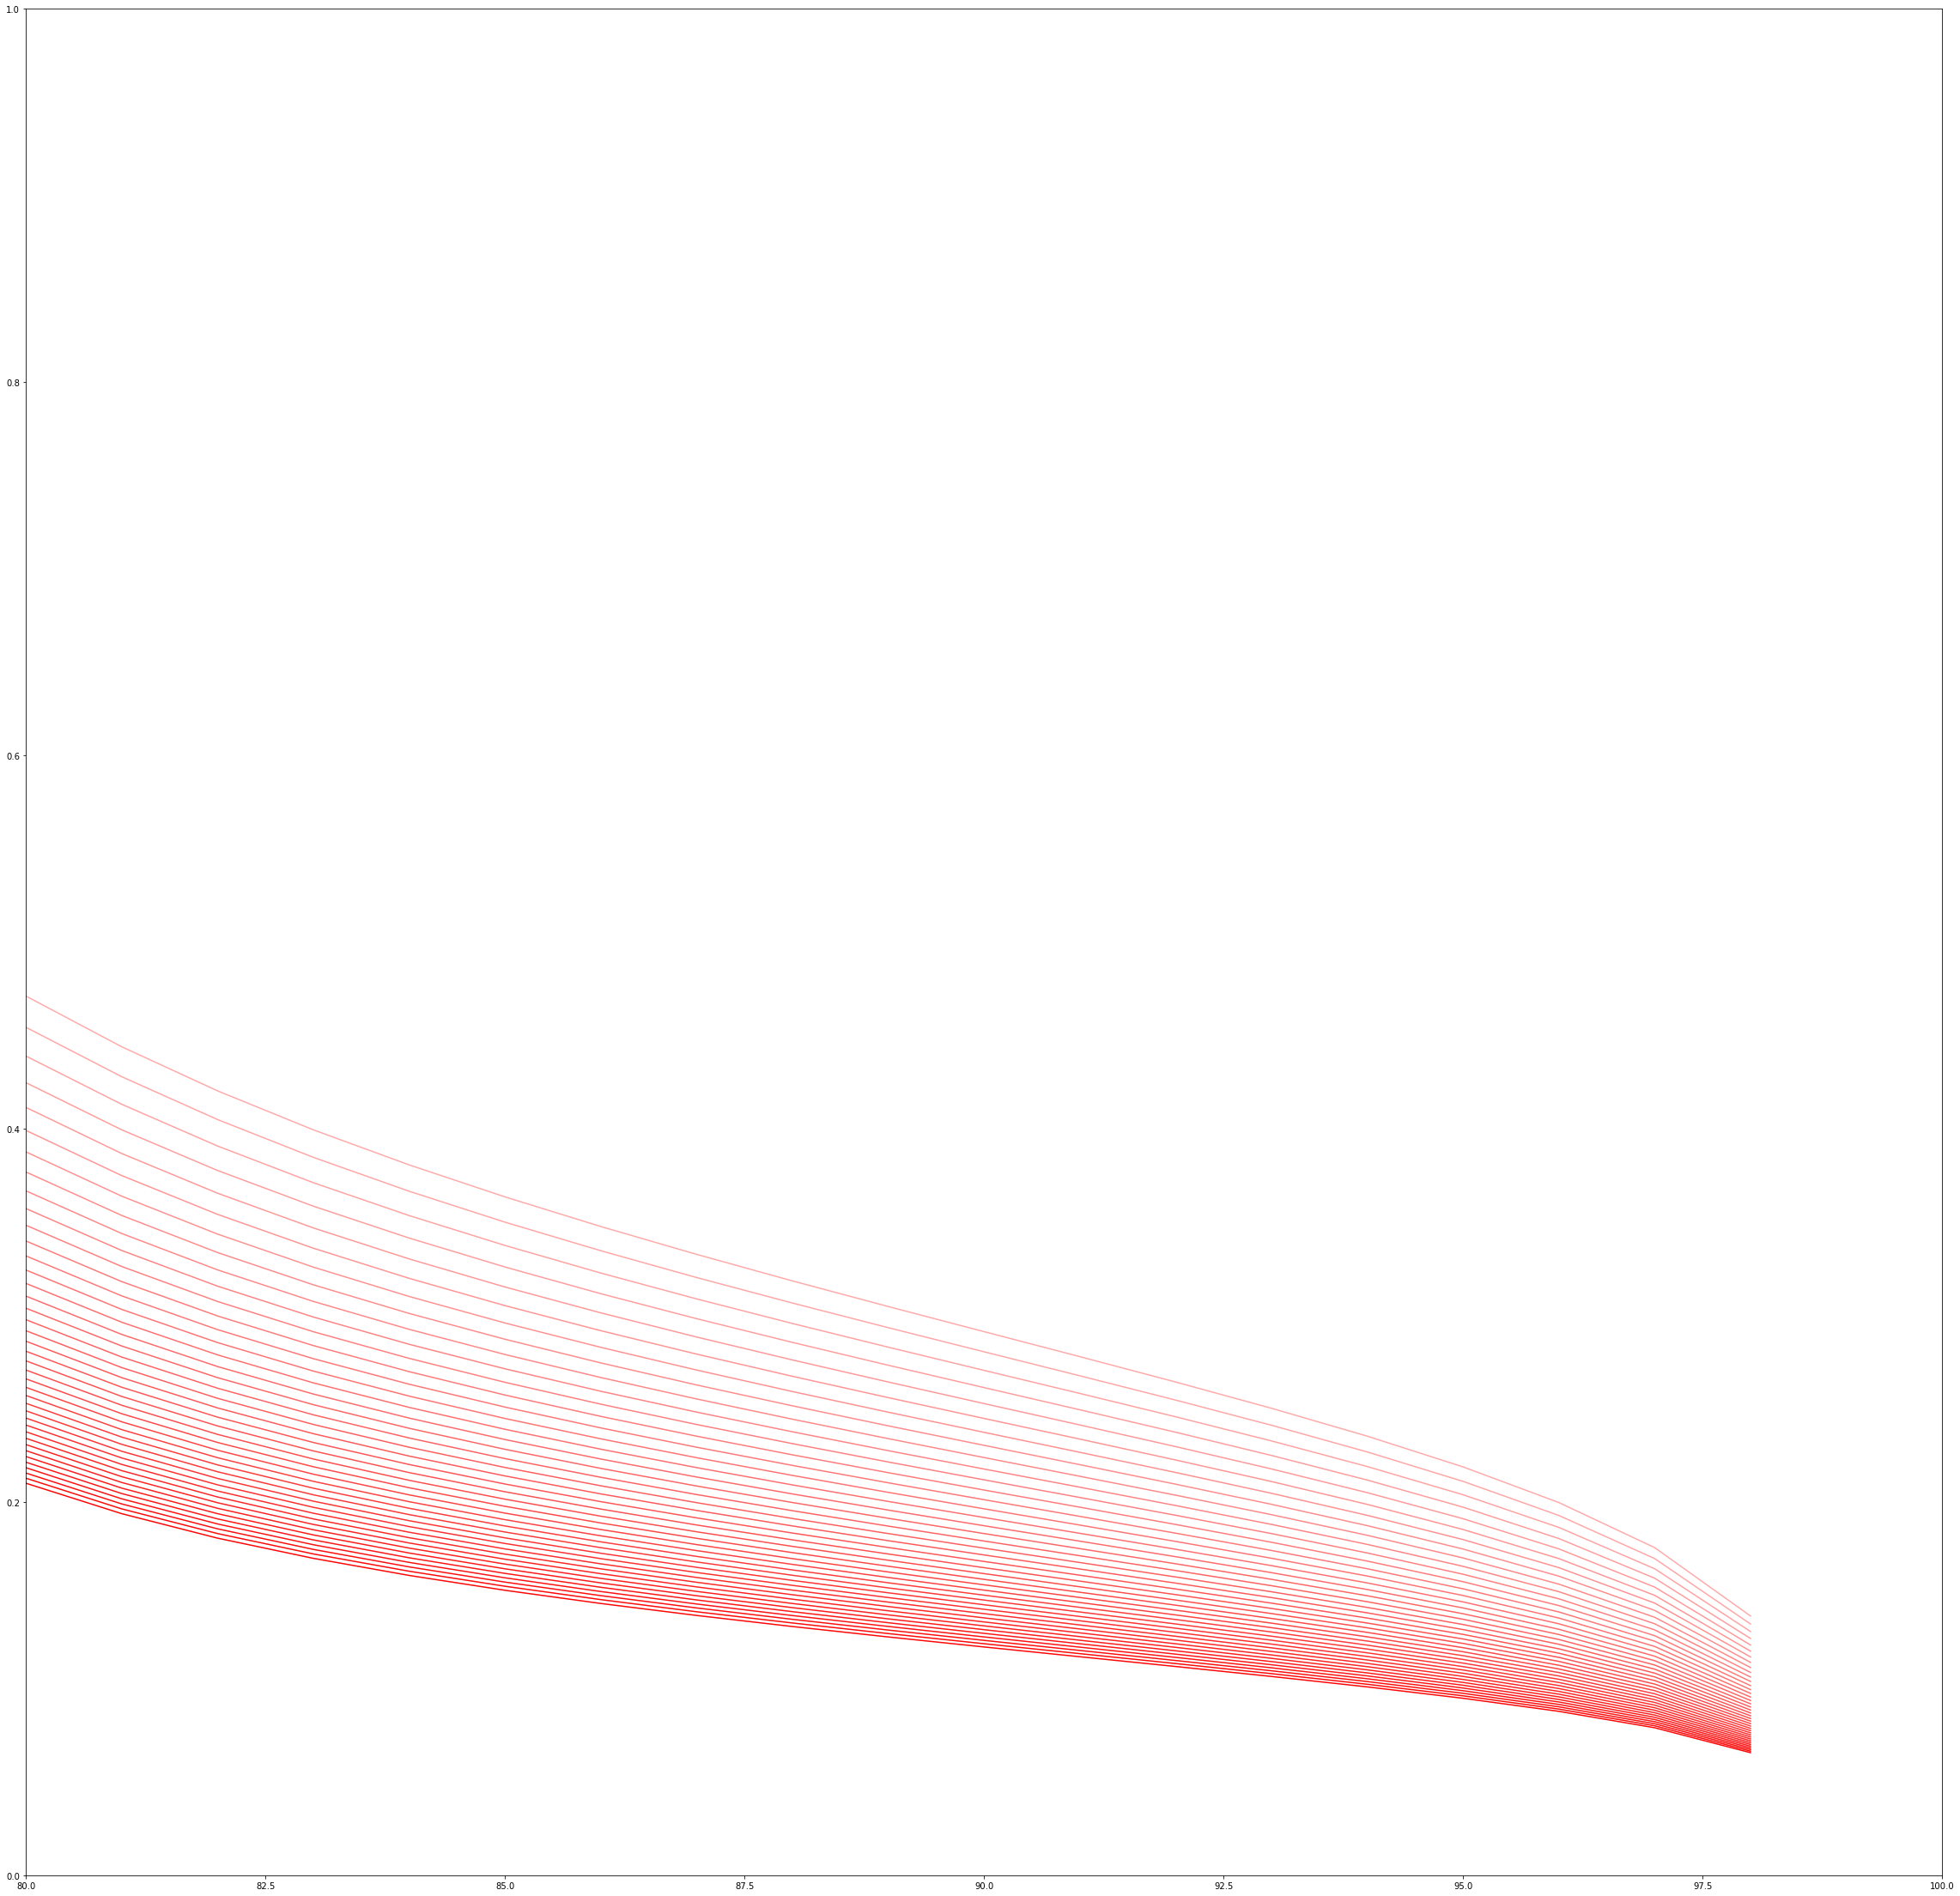

In [498]:
p.figure(figsize=(40,40))
p.xlim([80, 100])
p.ylim([0, 1])
#pass
for j in range(20, len(timings)):
    c = j / len(timings)
    p.plot(timings[j] / (j+1), c=(1, 1-c, 1-c))
p.show()

In [514]:
test = logmon(20000, 0.9).values

In [674]:
tzzz = harmonicwgt(20000, FRAC(9, 10)).values

19900
19800
19700
19600
19500
19400
19300
19200
19100
19000
18900
18800
18700
18600
18500
18400
18300
18200
18100
18000
17900
17800
17700
17600
17500
17400
17300
17200
17100
17000
16900
16800
16700
16600
16500
16400
16300
16200
16100
16000
15900
15800
15700
15600
15500
15400
15300
15200
15100
15000
14900
14800
14700
14600
14500
14400
14300
14200
14100
14000
13900
13800
13700
13600
13500
13400
13300
13200
13100
13000
12900
12800
12700
12600
12500
12400
12300
12200
12100
12000
11900
11800
11700
11600
11500
11400
11300
11200
11100
11000
10900
10800
10700
10600
10500
10400
10300
10200
10100
10000
9900
9800
9700
9600
9500
9400
9300
9200
9100
9000
8900
8800
8700
8600
8500
8400
8300
8200
8100
8000
7900
7800
7700
7600
7500
7400
7300
7200
7100
7000
6900
6800
6700
6600
6500
6400
6300
6200
6100
6000
5900
5800
5700
5600
5500
5400
5300
5200
5100
5000
4900
4800
4700
4600
4500
4400
4300
4200
4100
4000
3900
3800
3700
3600


KeyboardInterrupt: 

We pretend that the distribution has the form ${1 \over \alpha}, 1, \alpha, \ldots$ and try to find $\alpha$.
$${q \over \alpha} = 1 - {1-q \over 2} - {1 - q \over 2 \alpha} ((1 - \alpha) \log 1 - \alpha + \alpha)$$
$${1 \over \alpha} = {1 \over 2} + {1 \over 2q} - {1 - q \over 2q} - {1 - q \over 2 q\alpha} (1 - \alpha) \log 1 - \alpha$$

In [662]:
tzzz[300:400]

array([2.62131486, 2.62127103, 2.62122722, 2.62118342, 2.62113963,
       2.62109586, 2.6210521 , 2.62100834, 2.6209646 , 2.62092087,
       2.62087716, 2.62083345, 2.62078976, 2.62074607, 2.6207024 ,
       2.62065874, 2.62061509, 2.62057146, 2.62052783, 2.62048422,
       2.62044061, 2.62039702, 2.62035344, 2.62030987, 2.62026631,
       2.62022276, 2.62017922, 2.6201357 , 2.62009218, 2.62004868,
       2.62000518, 2.6199617 , 2.61991823, 2.61987477, 2.61983132,
       2.61978788, 2.61974445, 2.61970103, 2.61965762, 2.61961422,
       2.61957084, 2.61952746, 2.61948409, 2.61944074, 2.61939739,
       2.61935406, 2.61931073, 2.61926742, 2.61922412, 2.61918082,
       2.61913754, 2.61909426, 2.619051  , 2.61900775, 2.6189645 ,
       2.61892127, 2.61887805, 2.61883484, 2.61879163, 2.61874844,
       2.61870526, 2.61866208, 2.61861892, 2.61857577, 2.61853262,
       2.61848949, 2.61844636, 2.61840325, 2.61836014, 2.61831705,
       2.61827396, 2.61823089, 2.61818782, 2.61814476, 2.61810

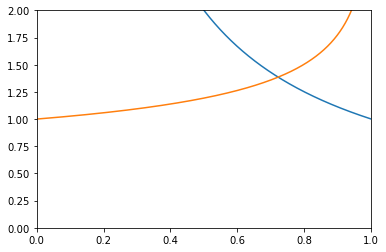

In [846]:
def f(alpha):
    return 1/alpha

def g(alpha, q):
    return q/2 + 1/2/q - (1-q)/2/alpha/q*(1-alpha)*np.log(1-alpha)

def f(alpha):
    return 1+alpha*0

def g(alpha, q):
    return q/alpha + (1-q)/2 + (1-q)/2 * ((1 - alpha) * np.log(1 - alpha) + alpha) / alpha

def f(alpha):
    return (1/alpha - 1) / (1 - alpha)

def g(alpha, q):
    return ((1 + q) / 2 / q - (1 - q) / 2 / q * ((1/alpha - 1) * np.log(1 - alpha) + alpha) - 1) / (1 - alpha)

what = np.linspace(0.001, 0.9999, 1000)
p.xlim([0, 1])
p.ylim([0, 2])
p.plot(what, f(what))
p.plot(what, g(what, 0.5))
p.show()


In [844]:
np.log(1 - np.exp(-2))

-0.14541345786885906

In [830]:
g(0.9999999999, 0.5)

0.9999999994743537

In [822]:
out = sp.optimize.bisect(lambda alpha: f(alpha) - g(alpha, 0.5), a=0.01, b=0.999999999)

In [824]:
out

0.864664716762867

In [825]:
np.log(1/out)

0.14541345786946083

In [820]:
tesv = logmon(100000, 0.7).values

In [772]:
def checkharmonic():
    foo = 0.864664
    total = 0.5/foo
    total += 0.25
    totala = 0
    for j in range(1, 1000):
        totala += 0.25 * (1/j/(j+1)) * foo**j
    totalb = 0.25 * ((1 - foo) * np.log(1 - foo) + foo) / foo
    print(totala, totalb)
    total += totalb
    total -= 1
    return total

checkharmonic()#

0.17174090651550333 0.1717409065155035


2.0723809623923728e-07

In [816]:
tesv[4000] - tesv[4001]

0.009685966437537274

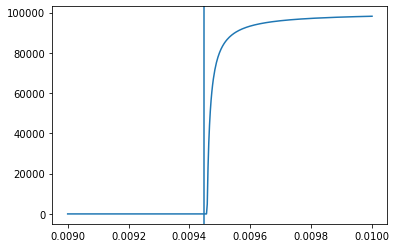

In [821]:
fooo = np.linspace(0.009, 0.010, 400)
p.axvline(0.009448055189994009)
p.plot(fooo, np.sum((tesv[:-1] - tesv[1:])[:, None] < fooo[None, :], axis=0))

In [799]:
that = tesv[:-2] - 2*tesv[1:-1] + tesv[2:]

In [804]:
that[-200:]

array([-7.68091393e-06, -7.78325959e-06, -7.88721968e-06, -7.99282569e-06,
       -8.10010986e-06, -8.20910524e-06, -8.31984568e-06, -8.43236587e-06,
       -8.54670137e-06, -8.66288861e-06, -8.78096493e-06, -8.90096862e-06,
       -9.02293895e-06, -9.14691618e-06, -9.27294159e-06, -9.40105755e-06,
       -9.53130749e-06, -9.66373601e-06, -9.79838885e-06, -9.93531296e-06,
       -1.00745565e-05, -1.02161691e-05, -1.03602014e-05, -1.05067056e-05,
       -1.06557353e-05, -1.08073455e-05, -1.09615929e-05, -1.11185354e-05,
       -1.12782329e-05, -1.14407467e-05, -1.16061400e-05, -1.17744775e-05,
       -1.19458260e-05, -1.21202543e-05, -1.22978327e-05, -1.24786341e-05,
       -1.26627332e-05, -1.28502069e-05, -1.30411344e-05, -1.32355973e-05,
       -1.34336796e-05, -1.36354677e-05, -1.38410509e-05, -1.40505209e-05,
       -1.42639724e-05, -1.44815030e-05, -1.47032132e-05, -1.49292067e-05,
       -1.51595905e-05, -1.53944750e-05, -1.56339740e-05, -1.58782051e-05,
       -1.61272896e-05, -

In [532]:
fps(Rational(1,2) + Rational(1, 2)/q + (1 - q) / 2/q * (1 - z) * log(1 - z), z)

FormalPowerSeries(1/2 + (1/2 - q/2)*(1 - z)*log(1 - z)/q + 1/(2*q), z, 0, 1, (SeqFormula(Coeff(1/2, z, _k) + Coeff(1/(2*q), z, _k) - 1/(2*_k*(_k - 1)), (_k, 2, oo)), SeqFormula(z**_k, (_k, 0, oo)), z*(-z*log(1 - z)/(2*q) + log(1 - z)/(2*q))/2 + 1/2 + 1/(2*q)))

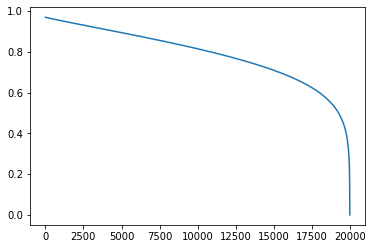

In [597]:
p.plot(test)

<ipython-input-388-fad0e7e4a2ba>:2: RuntimeWarning: invalid value encountered in log
  p.plot(np.log(timings))


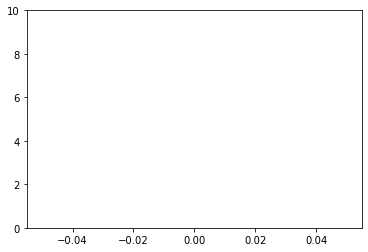

In [388]:
p.ylim([0, 10])
p.plot(np.log(timings))

In [ ]:
[simplify(j) for j in foo.values]

In [166]:
[j.subs({symbols('q'): Rational(1, 1)}) for j in foo.values]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]

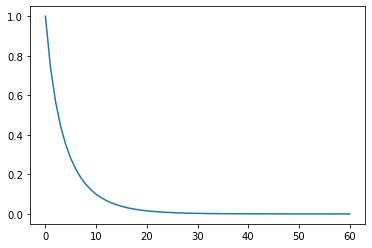

In [283]:
p.plot(eval(1, 2))

1


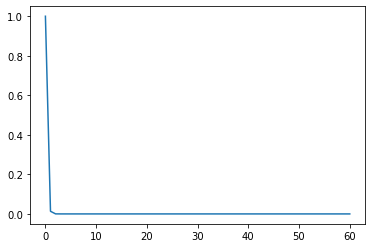

2


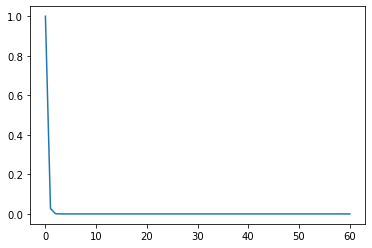

3


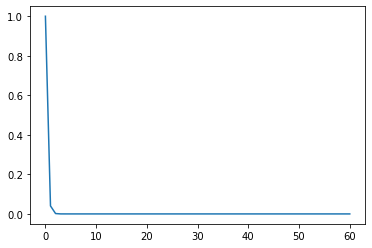

4


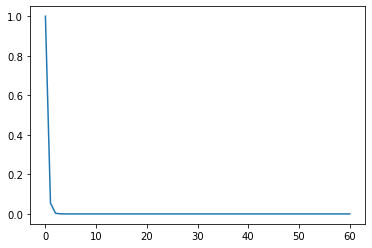

5


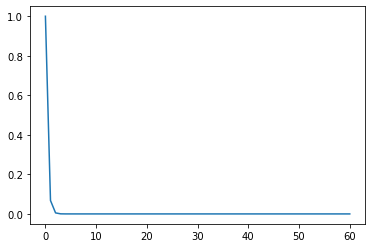

6


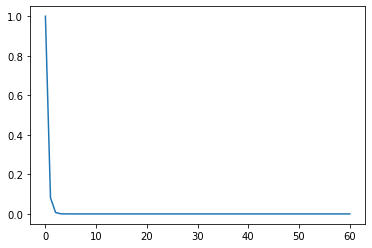

7


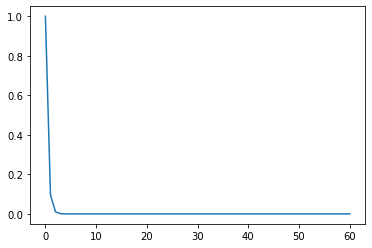

8


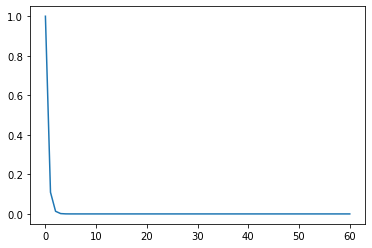

9


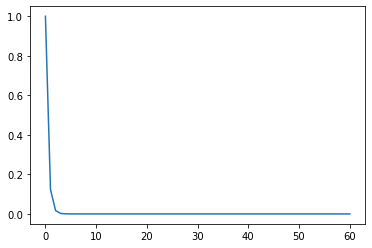

10


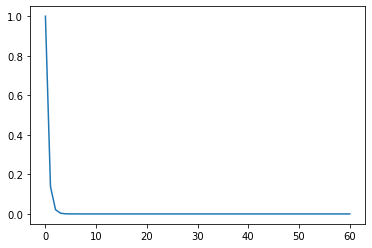

11


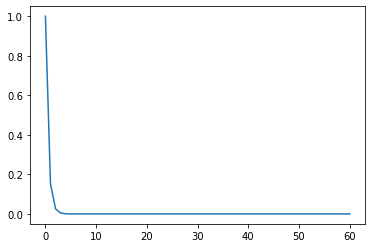

12


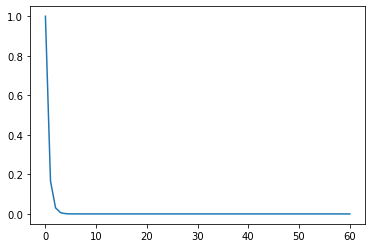

13


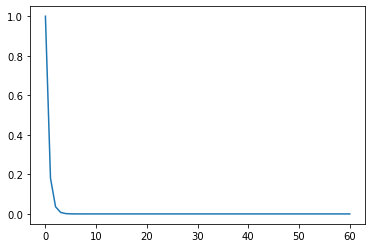

14


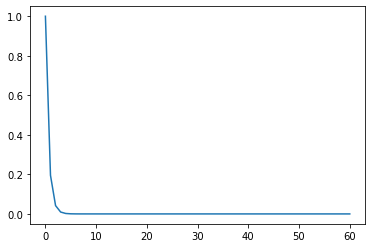

15


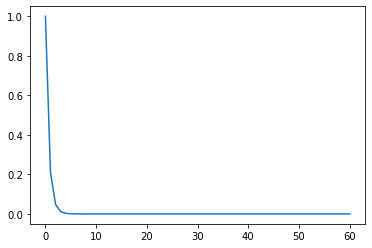

16


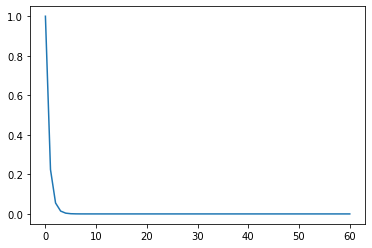

17


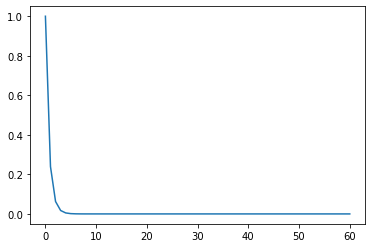

18


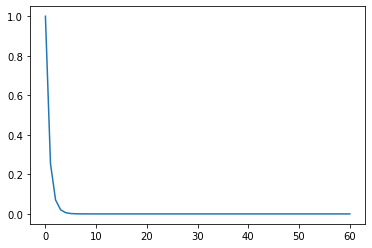

19


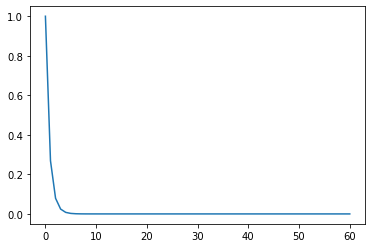

20


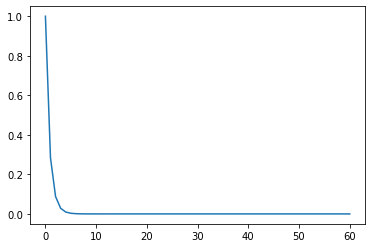

21


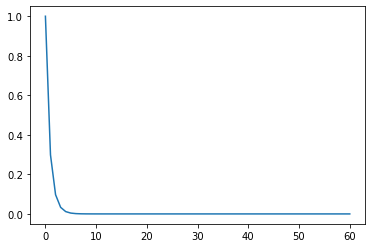

22


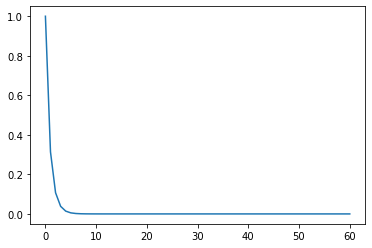

23


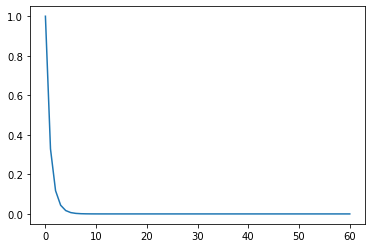

24


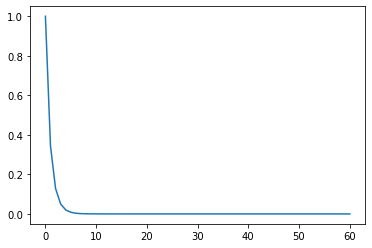

25


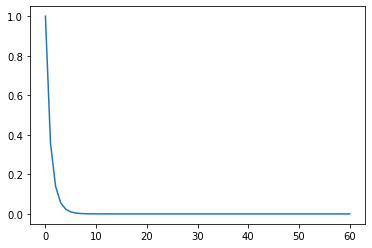

26


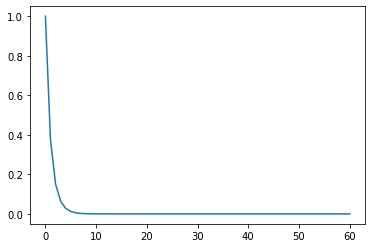

27


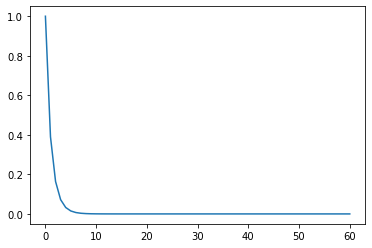

28


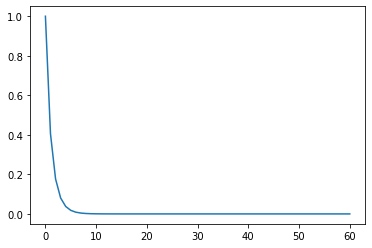

29


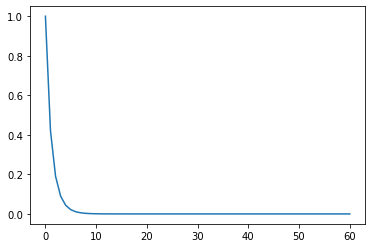

30


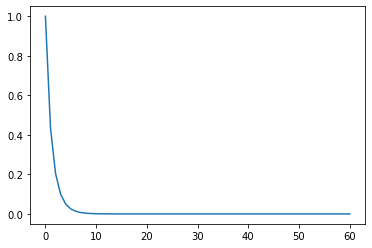

31


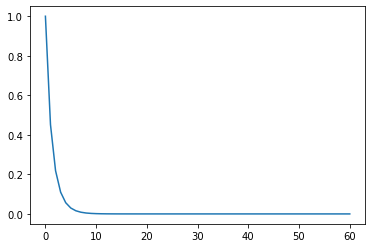

32


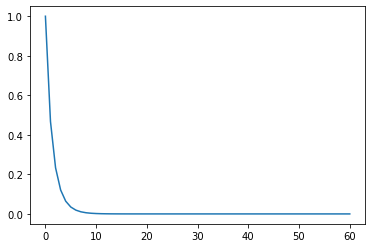

33


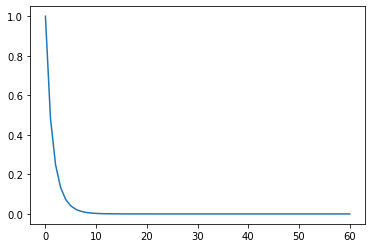

34


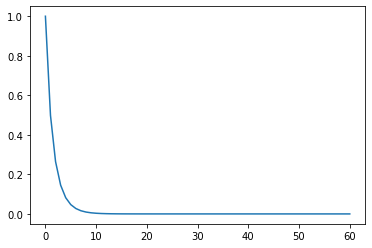

35


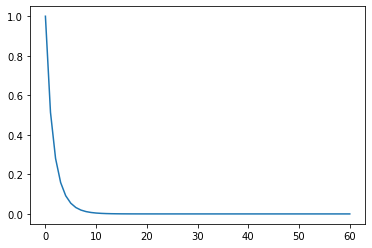

36


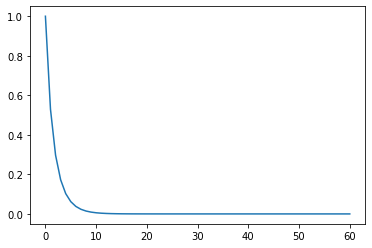

37


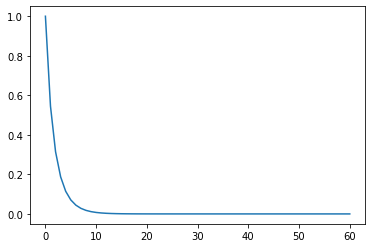

38


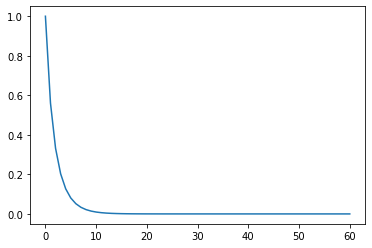

39


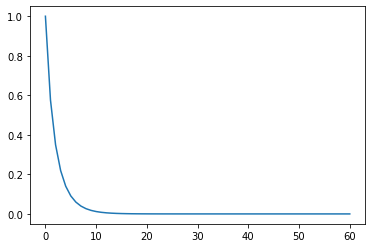

40


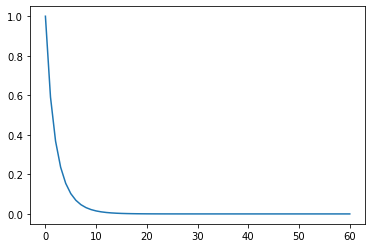

41


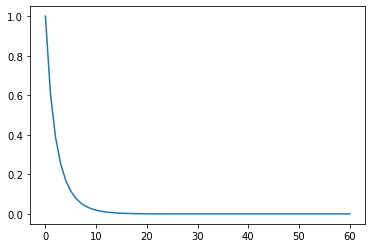

42


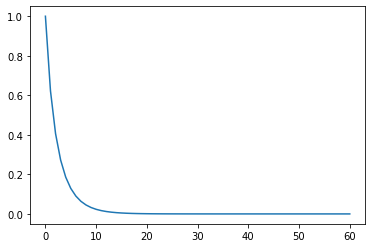

43


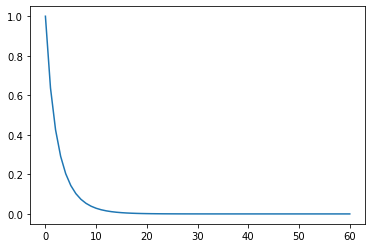

44


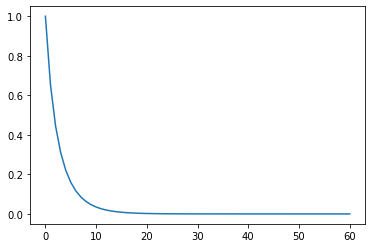

45


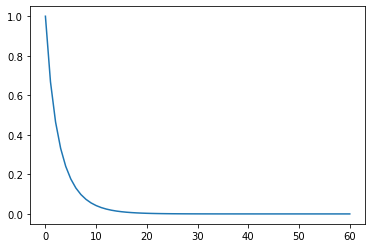

46


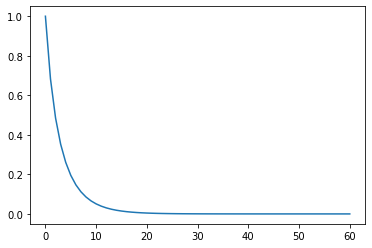

47


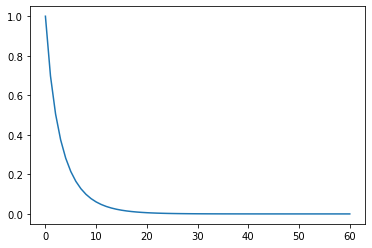

48


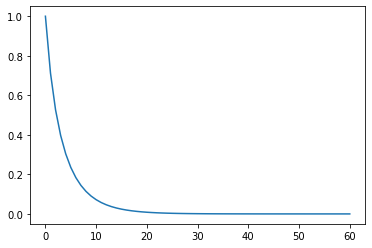

49


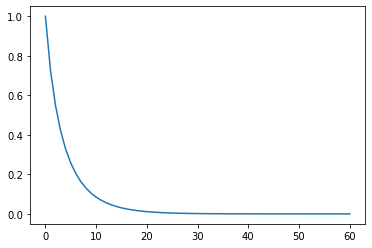

50


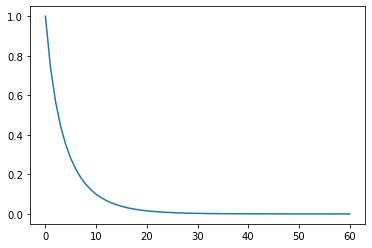

51


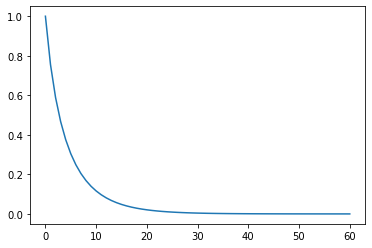

52


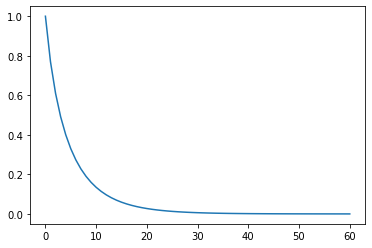

53


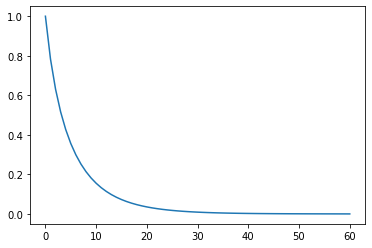

54


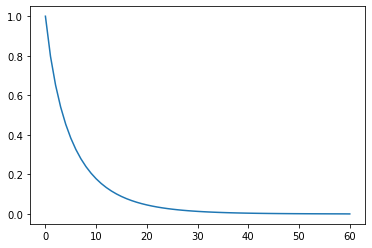

55


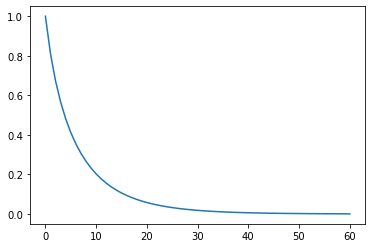

56


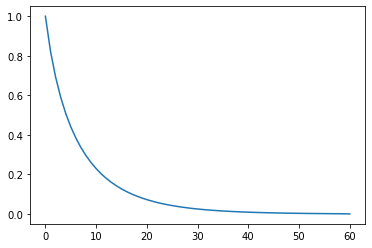

57


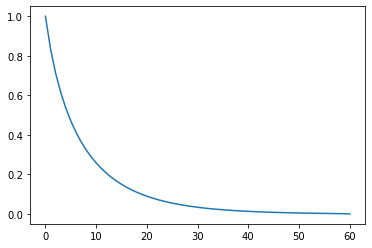

58


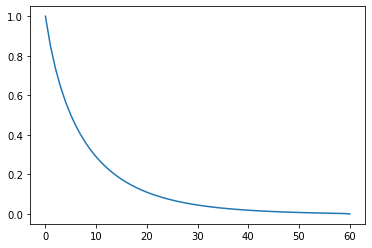

59


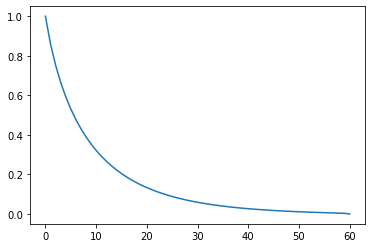

60


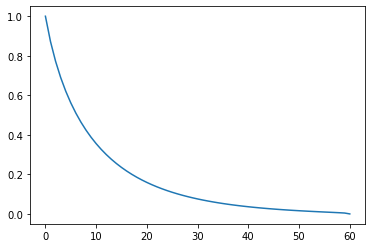

61


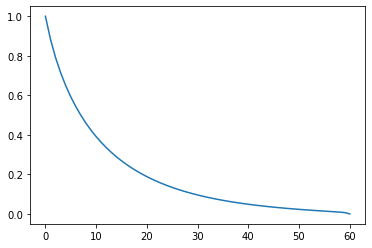

62


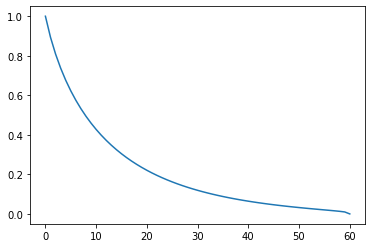

63


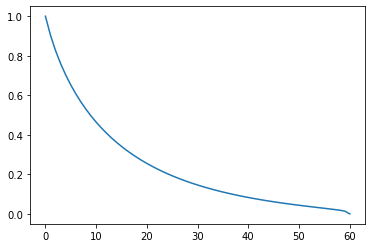

64


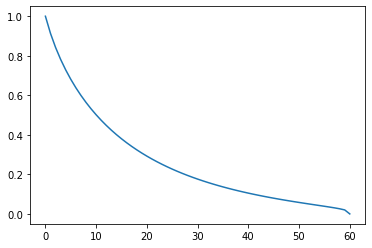

65


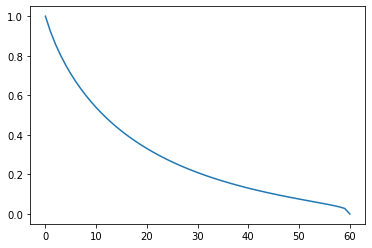

66


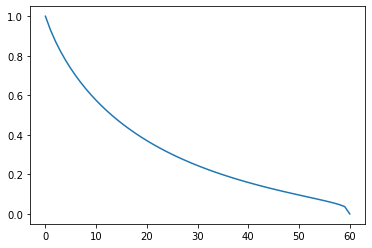

67


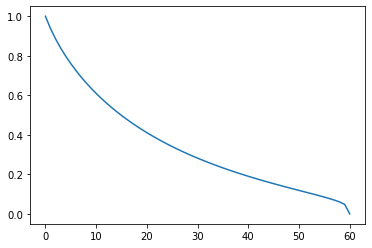

68


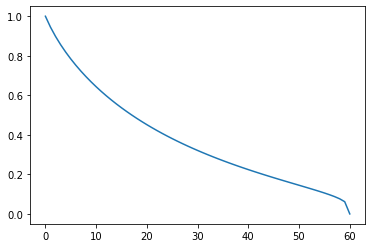

69


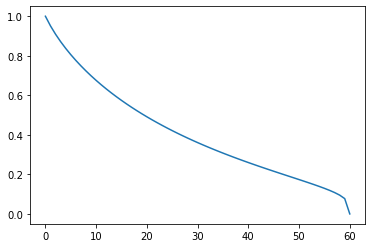

70


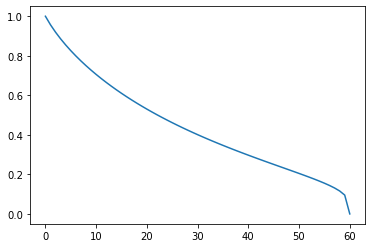

71


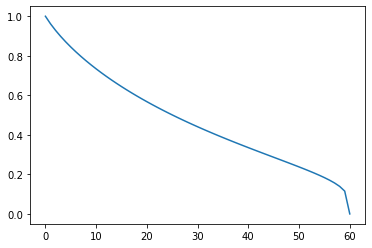

72


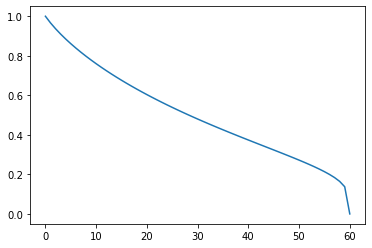

73


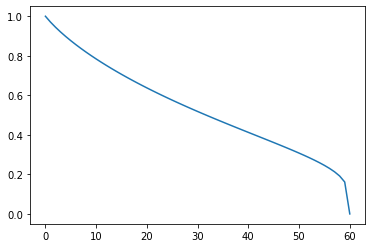

74


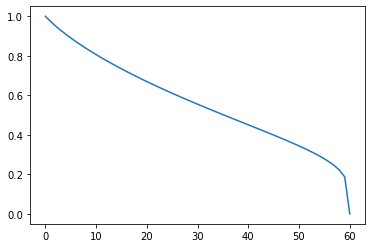

75


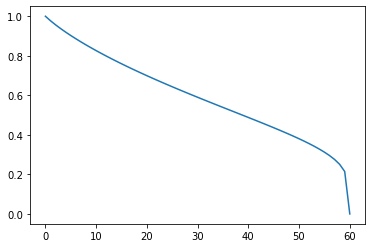

76


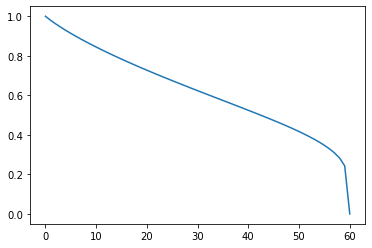

77


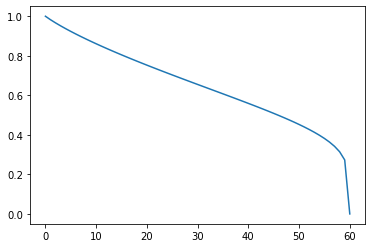

78


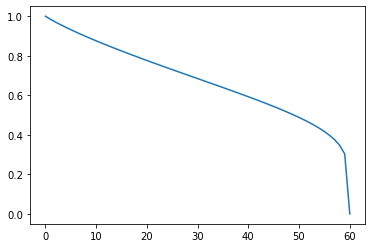

79


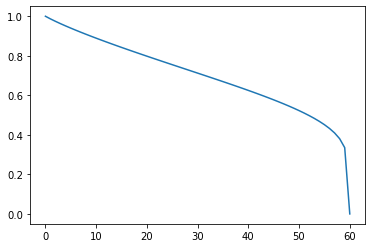

80


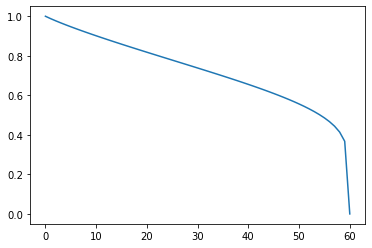

81


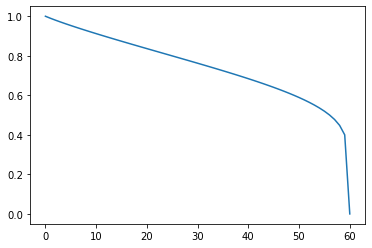

82


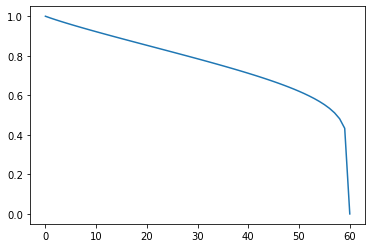

83


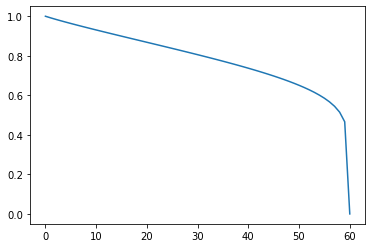

84


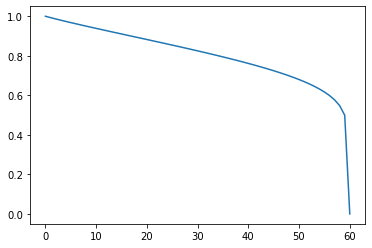

85


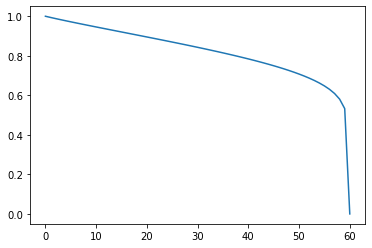

86


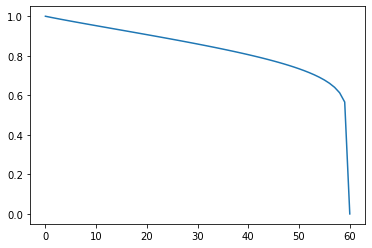

87


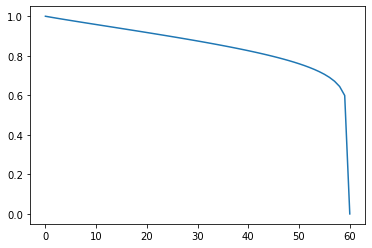

88


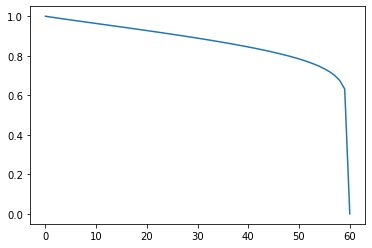

89


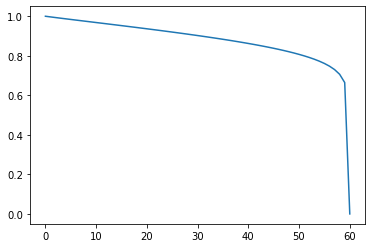

90


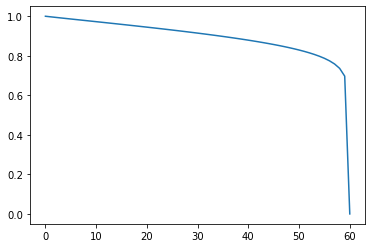

91


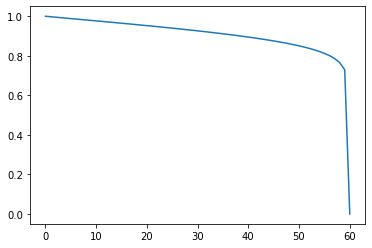

92


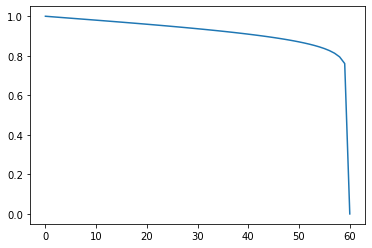

93


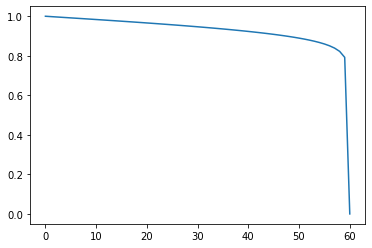

94


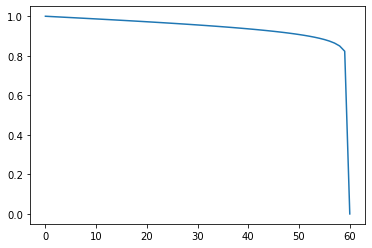

95


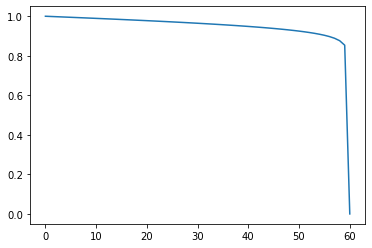

96


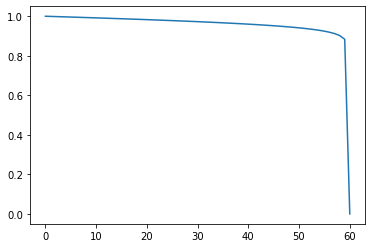

97


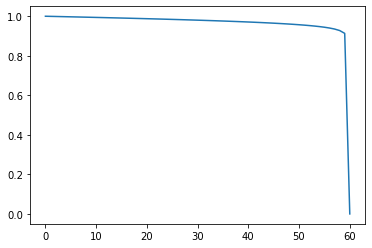

98


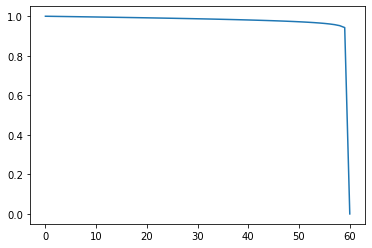

99


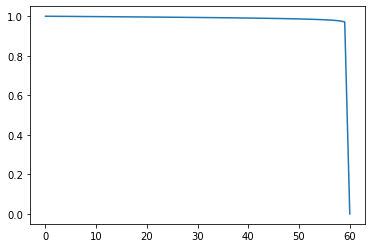

In [287]:
for j in range(1, 100):
    print(j)
    p.plot(eval(j, 100))
    p.show()

In [289]:
1/np.sqrt(2)

0.7071067811865475

In [237]:
(out - out[0]) / (out[-1] - out[0])

TypeError: unsupported operand type(s) for -: 'list' and 'Mul'

In [238]:
q = symbols('q')

In [276]:
foo = harmonicwgt(400, 0.9)
out = [expand(j) for j in foo.values]
out

subtracting
    0.0498750000000000
    0
from 1.00000000000000
subtracting
    0.0526524296853244
    0.0250003132832080
    0
from 1.05569444444444
subtracting
    0.0541991283481208
    0.0263926935044199
    0.00833364661654135
    0
from 1.08671300163990
subtracting
    0.0552930119137482
    0.0271681689244582
    0.00879778609701249
    0.00416697994987469
    0
from 1.10865281463424
subtracting
    0.0561482341134841
    0.0277166729638813
    0.00905628556379316
    0.00439905924516064
    0.00250031328320802
    0
from 1.12580763083239
subtracting
    0.0568549794474217
    0.0281455506377164
    0.00923912605331053
    0.00452831472362690
    0.00263956850441990
    0.00166697994987469
    0
from 1.13998562851429
subtracting
    0.0574599641729813
    0.0285000069615332
    0.00938209012384325
    0.00461973932566785
    0.00271712638756040
    0.00175982313404953
    0.00119078947368421
    0
from 1.15212345466436
subtracting
    0.0579906155941949
    0.0288034583985688
   

    5.94690932738862e-5
    5.54328316955533e-5
    5.17144319003689e-5
    4.82648044957987e-5
    4.50347728920842e-5
    4.19686946705912e-5
    3.89894382842503e-5
    3.59496147812731e-5
    3.23645652593021e-5
    0
from 1.30748982432974
subtracting
    0.0653207818444223
    0.0326877486437253
    0.0108744565023666
    0.00542635935527020
    0.00324920303681943
    0.00216166058592269
    0.00154079533732641
    0.00115311837047521
    0.000894906733824003
    0.000714323882423974
    0.000583108916740911
    0.000484784214949644
    0.000409214547147671
    0.000349887504724466
    0.000302463527389195
    0.000263960554203083
    0.000232274559335708
    0.000205886638790528
    0.000183678070224841
    0.000164810138332206
    0.000148644041574849
    0.000134686297466994
    0.000122550771808254
    0.000111931786229566
    0.000102584755209900
    9.43120320254386e-5
    8.69524159507073e-5
    8.03732692069916e-5
    7.44645162653989e-5
    6.91340126326414e-5
    6.4303

    0.000173217448871054
    0.000156465720388572
    0.000142006263223127
    0.000129439460282239
    0.000118449052343889
    0.000108782113899932
    0.000100234423436343
    9.26396290310775e-5
    8.58611243391642e-5
    7.97858868643426e-5
    7.43197549342953e-5
    6.93837718647904e-5
    6.49113303277249e-5
    6.08459227794095e-5
    5.71393552131377e-5
    5.37503182118854e-5
    5.06432357839783e-5
    4.77873318005663e-5
    4.51558680938675e-5
    4.27255188552238e-5
    4.04758538961524e-5
    3.83889093126391e-5
    3.64488286272440e-5
    3.46415609358200e-5
    3.29546052134064e-5
    3.13767919187528e-5
    2.98980945010913e-5
    2.85094644268826e-5
    2.72026839261290e-5
    2.59702307577875e-5
    2.48051487565818e-5
    2.37009164021594e-5
    2.26513024141590e-5
    2.16501908548816e-5
    2.06913448890937e-5
    1.97680497151818e-5
    1.88725088790245e-5
    1.79946982167031e-5
    1.71198819730480e-5
    1.62222148697567e-5
    1.52433317896422e-5
    1.397

    0.000951793564527784
    0.000760599864714327
    0.000621627575767652
    0.000517456234613070
    0.000437368626881998
    0.000374477088298107
    0.000324191157972665
    0.000283355797943908
    0.000249744560292766
    0.000221749915088442
    0.000198187705395839
    0.000178170067310866
    0.000161020726168949
    0.000146217254993128
    0.000133350914131128
    0.000122098209764660
    0.000112200419945680
    0.000103448635708340
    9.56726825233306e-5
    8.87328129702099e-5
    8.25134058238683e-5
    7.69181362690691e-5
    7.18662374169614e-5
    6.72895801625413e-5
    6.31303728942428e-5
    5.93393351287193e-5
    5.58742366832593e-5
    5.26987211065502e-5
    4.97813518676472e-5
    4.70948343751864e-5
    4.46153777331543e-5
    4.23221682641090e-5
    4.01969329728347e-5
    3.82235758023780e-5
    3.63878731246343e-5
    3.46772176813747e-5
    3.30804023484360e-5
    3.15874367832497e-5
    3.01893913437809e-5
    2.88782637176106e-5
    2.76468645354615e-

    0.000288424085963466
    0.000254268775659553
    0.000225819300311749
    0.000201872905176136
    0.000181527752190315
    0.000164096900226687
    0.000149049665157405
    0.000135970833737181
    0.000124531778310526
    0.000114469662909463
    0.000105572250272929
    9.76666496853433e-5
    9.06108792787217e-5
    8.42874660995714e-5
    7.85985403202552e-5
    7.34620378485406e-5
    6.88087341152740e-5
    6.45799074510879e-5
    6.07254838436056e-5
    5.72025529912902e-5
    5.39741731014698e-5
    5.10084019682808e-5
    4.82775066664374e-5
    4.57573152007437e-5
    4.34266817033388e-5
    4.12670430093221e-5
    3.92620491941343e-5
    3.73972543030864e-5
    3.56598563212501e-5
    3.40384776233079e-5
    3.25229788577453e-5
    3.11043005695382e-5
    2.97743279339163e-5
    2.85257748240467e-5
    2.73520841155879e-5
    2.62473416777243e-5
    2.52062019417346e-5
    2.42238232962137e-5
    2.32958118497412e-5
    2.24181723403291e-5
    2.15872651668341e-5
    2

    9.36064715472368e-6
    9.11569759124297e-6
    8.87819546167626e-6
    8.64768074214363e-6
    8.42370030316564e-6
    8.20580283652821e-6
    7.99353270463886e-6
    7.78642219956660e-6
    7.58398143337545e-6
    7.38568464081715e-6
    7.19095091925440e-6
    6.99911607984904e-6
    6.80938975524575e-6
    6.62078690415057e-6
    6.43201226003871e-6
    6.24125191496696e-6
    6.04576403208802e-6
    5.84097829562820e-6
    5.61816516147502e-6
    5.35663871353070e-6
    4.98094564267278e-6
    0
from 1.42027354455607
subtracting
    0.0708390905044303
    0.0355076463952881
    0.0118254239792750
    0.00590757769797899
    0.00354152074405380
    0.00235903161469009
    0.00168363072707342
    0.00126169641179475
    0.000980533781713952
    0.000783808320383529
    0.000640799160662121
    0.000533589909555174
    0.000451157625257261
    0.000386417757692444
    0.000334648357879106
    0.000292603831303061
    0.000257993696139974
    0.000229164095360190
    0.00020489667

subtracting
    0.0715241456538692
    0.0358580634496013
    0.0119429425282014
    0.00596671082363637
    0.00357723527784587
    0.00238300457853938
    0.00170087573991053
    0.00127472487705022
    0.000990743478443332
    0.000792039451172197
    0.000647587378610125
    0.000539292970741030
    0.000456023661051656
    0.000390624330272944
    0.000338325919199420
    0.000295850400988445
    0.000260884369329261
    0.000231757388188980
    0.000207238873250917
    0.000186406083678086
    0.000168556129174478
    0.000153145983357850
    0.000139750759885605
    0.000128034162260918
    0.000117727210729303
    0.000108612698767801
    0.000100513681016631
    9.32848404603579e-5
    8.68059403277933e-5
    8.09768045985769e-5
    7.57134324985108e-5
    7.09449633823628e-5
    6.66112857707382e-5
    6.26611389150413e-5
    5.90505942661457e-5
    5.57418323875273e-5
    5.27021514045997e-5
    4.99031582233770e-5
    4.73201050095019e-5
    4.49313418613015e-5
    4.271786

    7.01327895435916e-6
    6.86087985832769e-6
    6.71254050558833e-6
    6.56806706452497e-6
    6.42727109458399e-6
    6.28996856186407e-6
    6.15597877336767e-6
    6.02512319546088e-6
    5.89722411121995e-6
    5.77210305585420e-6
    5.64957894701336e-6
    5.52946579392475e-6
    5.41156982015706e-6
    5.29568575975118e-6
    5.18159196909916e-6
    5.06904380847238e-6
    4.95776443504962e-6
    4.84743161434153e-6
    4.73765820215585e-6
    4.62796216318580e-6
    4.51771845957013e-6
    4.40607766949865e-6
    4.29181902199402e-6
    4.17306170017004e-6
    4.04662979456803e-6
    3.90640969208544e-6
    3.73785925860923e-6
    3.48788638262322e-6
    0
from 1.44750947672547
subtracting
    0.0721694963427556
    0.0361886974420099
    0.0120537565834953
    0.00602243646213085
    0.00361087200545737
    0.00240556997081218
    0.00171709922233838
    0.00128697496938322
    0.00100033814253578
    0.000799770736689277
    0.000653960128609412
    0.000544644289595251


    0.000806442532106515
    0.000659457918153702
    0.000549259568087270
    0.000464522167455251
    0.000397966546497154
    0.000344740851602855
    0.000301510070092809
    0.000265920524697250
    0.000236272661822124
    0.000211314417805226
    0.000190106924076792
    0.000171934988662572
    0.000156246068614962
    0.000142607821457191
    0.000130678041284883
    0.000120183015515718
    0.000110901710682402
    0.000102654059697307
    9.52921784199919e-5
    8.86937032124719e-5
    8.27566837157134e-5
    7.73956293739456e-5
    7.25384211753460e-5
    6.81238787880913e-5
    6.40998288263579e-5
    6.04215596600516e-5
    5.70505768368155e-5
    5.39535940933197e-5
    5.11017103377632e-5
    4.84697344394904e-5
    4.60356282513702e-5
    4.37800447847263e-5
    4.16859434040967e-5
    3.97382677056944e-5
    3.79236746769198e-5
    3.62303060156759e-5
    3.46475942735339e-5
    3.31660978921165e-5
    3.17773603145236e-5
    3.04737892389696e-5
    2.92485527900195e-

    2.18881923053745e-5
    2.11439923544529e-5
    2.04369823678739e-5
    1.97647161616406e-5
    1.91249451451850e-5
    1.85155994749856e-5
    1.79347712714131e-5
    1.73806996446679e-5
    1.68517573103500e-5
    1.63464386046949e-5
    1.58633487346696e-5
    1.54011941196272e-5
    1.49587736996573e-5
    1.45349711016035e-5
    1.41287475673552e-5
    1.37391355607906e-5
    1.33652329799190e-5
    1.30061979095935e-5
    1.26612438578179e-5
    1.23296354253377e-5
    1.20106843640068e-5
    1.17037459844996e-5
    1.14082158783685e-5
    1.11235269233385e-5
    1.08491465441451e-5
    1.05845742042196e-5
    1.03293391061729e-5
    1.00829980813591e-5
    9.84513365086106e-6
    9.61535224206021e-6
    9.39328254657134e-6
    9.17857400675055e-6
    8.97089541925941e-6
    8.76993364529790e-6
    8.57539241812521e-6
    8.38699123938452e-6
    8.20446435654672e-6
    8.02755981450190e-6
    7.85603857496321e-6
    7.68967369791644e-6
    7.52824957985496e-6
    7.3715612439

    0.000214512306294480
    0.000193010418272884
    0.000174585528273417
    0.000158677604546527
    0.000144848438389895
    0.000132751175502746
    0.000122108381138690
    0.000112696012678027
    0.000104331548854375
    9.68650877210768e-5
    9.01725941781566e-5
    8.41507236848847e-5
    7.87128152825643e-5
    7.37857615116256e-5
    6.93075425756506e-5
    6.52252684077449e-5
    6.14936125078037e-5
    5.80735504597614e-5
    5.49313372279990e-5
    5.20376729446080e-5
    4.93670185076163e-5
    4.68970310158957e-5
    4.46080956482593e-5
    4.24829356085520e-5
    4.05062856064192e-5
    3.86646173165667e-5
    3.69459075715818e-5
    3.53394418528262e-5
    3.38356470682653e-5
    3.24259487336114e-5
    3.11026485705057e-5
    2.98588192532812e-5
    2.86882136128705e-5
    2.75851860724481e-5
    2.65446244674553e-5
    2.55618907106875e-5
    2.46327690151227e-5
    2.37534205941591e-5
    2.29203439295852e-5
    2.21303398388334e-5
    2.13804806903446e-5
    2.0

    1.03646973624468e-5
    1.01235086928545e-5
    9.89054016576512e-6
    9.66541635489161e-6
    9.44778290930166e-6
    9.23730514327562e-6
    9.03366673459107e-6
    8.83656852178187e-6
    8.64572739183239e-6
    8.46087525058497e-6
    8.28175806886869e-6
    8.10813499801188e-6
    7.93977754898709e-6
    7.77646882996337e-6
    7.61800283751385e-6
    7.46418379715149e-6
    7.31482554924858e-6
    7.16975097674053e-6
    7.02879147132492e-6
    6.89178643514749e-6
    6.75858281521951e-6
    6.62903466803958e-6
    6.50300275209930e-6
    6.38035414613829e-6
    6.26096189118260e-6
    6.14470465455188e-6
    6.03146641415762e-6
    5.92113616153735e-6
    5.81360762218016e-6
    5.70877899179669e-6
    5.60655268727451e-6
    5.50683511113605e-6
    5.40953642838330e-6
    5.31457035466995e-6
    5.22185395478933e-6
    5.13130745050340e-6
    5.04285403676573e-6
    4.95641970540796e-6
    4.87193307536432e-6
    4.78932522850164e-6
    4.70852955009999e-6
    4.6294815729

    1.50378763369146e-5
    1.46229555545167e-5
    1.42249958047529e-5
    1.38430782968462e-5
    1.34763455729783e-5
    1.31239966585067e-5
    1.27852826534961e-5
    1.24595027202622e-5
    1.21460004267864e-5
    1.18441604103837e-5
    1.15534053299611e-5
    1.12731930786845e-5
    1.10030142319280e-5
    1.07423897080736e-5
    1.04908686221064e-5
    1.02480263140483e-5
    1.00134625361353e-5
    9.78679978428642e-6
    9.56768176087684e-6
    9.35577195712666e-6
    9.15075234457226e-6
    8.95232216611864e-6
    8.76019681809042e-6
    8.57410681552082e-6
    8.39379683365309e-6
    8.21902481928726e-6
    8.04956116619523e-6
    7.88518794935756e-6
    7.72569821325129e-6
    7.57089530984688e-6
    7.42059228235831e-6
    7.27461129113817e-6
    7.13278307842375e-6
    6.99494646892360e-6
    6.86094790349050e-6
    6.73064100335864e-6
    6.60388616263290e-6
    6.48055016690819e-6
    6.36050583606964e-6
    6.24363168948035e-6
    6.12981163190583e-6
    6.0189346586

    0.000196630459944600
    0.000177892207096913
    0.000161712940407467
    0.000147647185140020
    0.000135342330284058
    0.000124516332159472
    0.000114941422648786
    0.000106432042518674
    9.88357923842662e-5
    9.20265686616893e-5
    8.58993016976031e-5
    8.03658825011442e-5
    7.53519808454909e-5
    7.07945385871889e-5
    6.66397792808654e-5
    6.28416160422330e-5
    5.93603691312006e-5
    5.61617262661963e-5
    5.32158945507220e-5
    5.04969046930185e-5
    4.79820370489841e-5
    4.56513457089097e-5
    4.34872619456977e-5
    4.14742622536792e-5
    3.95985892294091e-5
    3.78480158963012e-5
    3.62116459143442e-5
    3.46797435640495e-5
    3.32435885399737e-5
    3.18953515013547e-5
    3.06279870571168e-5
    2.94351414490849e-5
    2.83110726709978e-5
    2.72505811452449e-5
    2.62489493923889e-5
    2.53018893847247e-5
    2.44054964855471e-5
    2.35562090492952e-5
    2.27507729013122e-5
    2.19862100351891e-5
    2.12597909650105e-5
    2.05

    6.30481502006255e-6
    6.19260946792584e-6
    6.08329350758747e-6
    5.97676499014325e-6
    5.87292616344140e-6
    5.77168344196734e-6
    5.67294719034562e-6
    5.57663151952024e-6
    5.48265409474500e-6
    5.39093595457853e-6
    5.30140134013726e-6
    5.21397753391261e-6
    5.12859470750743e-6
    5.04518577769101e-6
    4.96368627021289e-6
    4.88403419085223e-6
    4.80616990321383e-6
    4.73003601281199e-6
    4.65557725701137e-6
    4.58274040041920e-6
    4.51147413534518e-6
    4.44172898696591e-6
    4.37345722284781e-6
    4.30661276649789e-6
    4.24115111462477e-6
    4.17702925780244e-6
    4.11420560423787e-6
    4.05263990634876e-6
    3.99229318986095e-6
    3.93312768513487e-6
    3.87510676042740e-6
    3.81819485678880e-6
    3.76235742428371e-6
    3.70756085921000e-6
    3.65377244196822e-6
    3.60096027520796e-6
    3.54909322184182e-6
    3.49814084247472e-6
    3.44807333174053e-6
    3.39886145296954e-6
    3.35047647052448e-6
    3.3028900790

    2.59549834763873e-6
    2.55969646925974e-6
    2.52420464782972e-6
    2.48898872469804e-6
    2.45401144150722e-6
    2.41923167817764e-6
    2.38460347486274e-6
    2.35007475818632e-6
    2.31558565557105e-6
    2.28106622447452e-6
    2.24643333192772e-6
    2.21158626856743e-6
    2.17640042238524e-6
    2.14071787562704e-6
    2.10433292513619e-6
    2.06696882060237e-6
    2.02823840958243e-6
    1.98757309917554e-6
    1.94408343097731e-6
    1.89625273782419e-6
    1.84114579412087e-6
    1.77176727863525e-6
    1.66259236173335e-6
    0
from 1.51689929644483
subtracting
    0.0755250761671013
    0.0379242439534103
    0.0126347630481300
    0.00631432233962015
    0.00378691272168962
    0.00252358791408594
    0.00180190285475191
    0.00135098227557363
    0.00105045566959302
    0.000840147032950695
    0.000687238135329335
    0.000572587951088485
    0.000484419197533831
    0.000415161927539413
    0.000359770284805701
    0.000314775775737887
    0.00027773042763

    5.10561923378470e-6
    5.02503442268782e-6
    4.94627306662356e-6
    4.86927766198837e-6
    4.79399289151705e-6
    4.72036552126708e-6
    4.64834430296950e-6
    4.57787988140853e-6
    4.50892470651407e-6
    4.44143294987087e-6
    4.37536042536656e-6
    4.31066451371758e-6
    4.24730409062706e-6
    4.18523945834293e-6
    4.12443228039730e-6
    4.06484551931927e-6
    4.00644337712425e-6
    3.94919123839158e-6
    3.89305561575069e-6
    3.83800409760311e-6
    3.78400529791347e-6
    3.73102880790779e-6
    3.67904514952091e-6
    3.62802573043789e-6
    3.57794280057531e-6
    3.52876940984879e-6
    3.48047936707158e-6
    3.43304719982621e-6
    3.38644811514661e-6
    3.34065796084123e-6
    3.29565318727885e-6
    3.25141080944705e-6
    3.20790836907829e-6
    3.16512389662013e-6
    3.12303587280306e-6
    3.08162318953071e-6
    3.04086510978275e-6
    3.00074122617754e-6
    2.96123141778928e-6
    2.92231580474983e-6
    2.88397470008586e-6
    2.8461885581

    1.99275822837222e-5
    1.93169965764302e-5
    1.87344179481432e-5
    1.81781485400967e-5
    1.76466173315757e-5
    1.71383689365757e-5
    1.66520535379719e-5
    1.61864178291091e-5
    1.57402968492276e-5
    1.53126066133429e-5
    1.49023374494564e-5
    1.45085479665778e-5
    1.41303595862236e-5
    1.37669515780386e-5
    1.34175565471256e-5
    1.30814563267200e-5
    1.27579782351336e-5
    1.24464916605103e-5
    1.21464049409962e-5
    1.18571625114791e-5
    1.15782422911837e-5
    1.13091532891679e-5
    1.10494334071931e-5
    1.07986474215951e-5
    1.05563851276817e-5
    1.03222596318686e-5
    1.00959057782647e-5
    9.87697869774323e-6
    9.66515246872292e-6
    9.46011887993603e-6
    9.26158628640236e-6
    9.06927855066973e-6
    8.88293406213357e-6
    8.70230482792315e-6
    8.52715562944606e-6
    8.35726323922576e-6
    8.19241569315507e-6
    8.03241161372760e-6
    7.87705958020490e-6
    7.72617754203382e-6
    7.57959227215113e-6
    7.4371388571

subtracting
    0.0763944689116868
    0.0383823870317931
    0.0127880816158111
    0.00639134968300367
    0.00383338777486665
    0.00255476779538736
    0.00182433099362991
    0.00136793274264160
    0.00106374871944703
    0.000850875627781449
    0.000696098322258985
    0.000580044120521293
    0.000490793105956430
    0.000420683589151564
    0.000364608519383255
    0.000319057309107451
    0.000281552256027493
    0.000250304167797942
    0.000223994882957086
    0.000201635923260389
    0.000182474271053986
    0.000165928132813960
    0.000151542257252814
    0.000138956288718846
    0.000127881983856742
    0.000118086563861223
    0.000109380384010731
    0.000101607686715799
    9.46395872714284e-5
    8.83686967893848e-5
    8.27049597112098e-5
    7.75724021809081e-5
    7.29065704053706e-5
    6.86524966085348e-5
    6.47630719525314e-5
    6.11977359623465e-5
    5.79214140001476e-5
    5.49036505519835e-5
    5.21178981472566e-5
    4.95409307740448e-5
    4.715235

    1.07602620233352e-5
    1.05231818872777e-5
    1.02939542969231e-5
    1.00722313566706e-5
    9.85768427651593e-6
    9.65000212494193e-6
    9.44889067575354e-6
    9.25407134085542e-6
    9.06528018172922e-6
    8.88226699304651e-6
    8.70479445246302e-6
    8.53263733118704e-6
    8.36558176040670e-6
    8.20342454910330e-6
    8.04597254917698e-6
    7.89304206417061e-6
    7.74445829820221e-6
    7.60005484201033e-6
    7.45967319328169e-6
    7.32316230867128e-6
    7.19037818514293e-6
    7.06118346845614e-6
    6.93544708680461e-6
    6.81304390777518e-6
    6.69385441694439e-6
    6.57776441656524e-6
    6.46466474292003e-6
    6.35445100102749e-6
    6.24702331549525e-6
    6.14228609640249e-6
    6.04014781918338e-6
    5.94052081756036e-6
    5.84332108864841e-6
    5.74846810941720e-6
    5.65588466375847e-6
    5.56549667946169e-6
    5.47723307445159e-6
    5.39102561168858e-6
    5.30680876217558e-6
    5.22451957555492e-6
    5.14409755781511e-6
    5.0654845556

    3.60480192497154e-6
    3.55815145408042e-6
    3.51234026198272e-6
    3.46734642890986e-6
    3.42314869476614e-6
    3.37972643233162e-6
    3.33705962151385e-6
    3.29512882458495e-6
    3.25391516234234e-6
    3.21340029113418e-6
    3.17356638069191e-6
    3.13439609271407e-6
    3.09587256014668e-6
    3.05797936710651e-6
    3.02070052939405e-6
    2.98402047554331e-6
    2.94792402835552e-6
    2.91239638686327e-6
    2.87742310867055e-6
    2.84299009261318e-6
    2.80908356168160e-6
    2.77569004614598e-6
    2.74279636682001e-6
    2.71038961839593e-6
    2.67845715277837e-6
    2.64698656233860e-6
    2.61596566300354e-6
    2.58538247708528e-6
    2.55522521574650e-6
    2.52548226098458e-6
    2.49614214700250e-6
    2.46719354081670e-6
    2.43862522193072e-6
    2.41042606087773e-6
    2.38258499640404e-6
    2.35509101102849e-6
    2.32793310466682e-6
    2.30110026595540e-6
    2.27458144084068e-6
    2.24836549791803e-6
    2.22244118990132e-6
    2.1967971104

    3.60758271763408e-6
    3.56145506247831e-6
    3.51615371489231e-6
    3.47165740281813e-6
    3.42794549643583e-6
    3.38499798273700e-6
    3.34279544112421e-6
    3.30131901997849e-6
    3.26055041413958e-6
    3.22047184324598e-6
    3.18106603088372e-6
    3.14231618449513e-6
    3.10420597599999e-6
    3.06671952308328e-6
    3.02984137110483e-6
    2.99355647558713e-6
    2.95785018523841e-6
    2.92270822546857e-6
    2.88811668235591e-6
    2.85406198702245e-6
    2.82053090037550e-6
    2.78751049817246e-6
    2.75498815636502e-6
    2.72295153667726e-6
    2.69138857237092e-6
    2.66028745414823e-6
    2.62963661614056e-6
    2.59942472192701e-6
    2.56964065052349e-6
    2.54027348227739e-6
    2.51131248459717e-6
    2.48274709743874e-6
    2.45456691846219e-6
    2.42676168776199e-6
    2.39932127206168e-6
    2.37223564824954e-6
    2.34549488611429e-6
    2.31908913011931e-6
    2.29300858002869e-6
    2.26724347016865e-6
    2.24178404707167e-6
    2.2166205452

    5.66993304419465e-6
    5.58178774092276e-6
    5.49567364898859e-6
    5.41152695980259e-6
    5.32928635628849e-6
    5.24889289606665e-6
    5.17028990096528e-6
    5.09342285246948e-6
    5.01823929274477e-6
    4.94468873089653e-6
    4.87272255414961e-6
    4.80229394365366e-6
    4.73335779463923e-6
    4.66587064066789e-6
    4.59979058173643e-6
    4.53507721601079e-6
    4.47169157497995e-6
    4.40959606183322e-6
    4.34875439287719e-6
    4.28913154181971e-6
    4.23069368675969e-6
    4.17340815973081e-6
    4.11724339865722e-6
    4.06216890158747e-6
    4.00815518308127e-6
    3.95517373263125e-6
    3.90319697500851e-6
    3.85219823242787e-6
    3.80215168843428e-6
    3.75303235341779e-6
    3.70481603166983e-6
    3.65747928989817e-6
    3.61099942712292e-6
    3.56535444587999e-6
    3.52052302466222e-6
    3.47648449153274e-6
    3.43321879884780e-6
    3.39070649903006e-6
    3.34892872133619e-6
    3.30786714956526e-6
    3.26750400065706e-6
    3.2278220041

    4.03644130364896e-5
    3.86496523378056e-5
    3.70437979988599e-5
    3.55377750591756e-5
    3.41234352318949e-5
    3.27934456267733e-5
    3.15411927547979e-5
    3.03606994624193e-5
    2.92465528429148e-5
    2.81938414979276e-5
    2.71981007885434e-5
    2.62552649340227e-5
    2.53616249966653e-5
    2.45137919405423e-5
    2.37086640757812e-5
    2.29433983033777e-5
    2.22153846618552e-5
    2.15222237495127e-5
    2.08617066569170e-5
    2.02317970956982e-5
    1.96306154531884e-5
    1.90564245393443e-5
    1.85076168237808e-5
    1.79827029875100e-5
    1.74803016368735e-5
    1.69991300467691e-5
    1.65379958171307e-5
    1.60957893411288e-5
    1.56714769960861e-5
    1.52640949789291e-5
    1.48727437173854e-5
    1.44965827962867e-5
    1.41348263454254e-5
    1.37867388415991e-5
    1.34516312828743e-5
    1.31288576978232e-5
    1.28178119566306e-5
    1.25179248546010e-5
    1.22286614417949e-5
    1.19495185753373e-5
    1.16800226734295e-5
    1.1419727652

    1.77353329829726e-6
    1.75457017045403e-6
    1.73572511230055e-6
    1.71698720433918e-6
    1.69834474701628e-6
    1.67978511799098e-6
    1.66129459943854e-6
    1.64285816733798e-6
    1.62445923205527e-6
    1.60607931585649e-6
    1.58769764778503e-6
    1.56929064886381e-6
    1.55083126965316e-6
    1.53228812589508e-6
    1.51362435313780e-6
    1.49479606246798e-6
    1.47575021731414e-6
    1.45642164850291e-6
    1.43672874877079e-6
    1.41656707423240e-6
    1.39579949414855e-6
    1.37424037228755e-6
    1.35162881621744e-6
    1.32758041414397e-6
    1.30149255976022e-6
    1.27233654734038e-6
    1.23812081428270e-6
    1.19410027989694e-6
    1.12297358242088e-6
    0
from 1.56649755336423
subtracting
    0.0778481307059157
    0.0391658513854157
    0.0130504628472730
    0.00652333940545661
    0.00391316661424568
    0.00260841025146830
    0.00186301810591212
    0.00139725824994130
    0.00108682211099423
    0.000869563762962922
    0.000711589984842301
 

    5.05005166784811e-6
    4.97784527878996e-6
    4.90716505778397e-6
    4.83796687666568e-6
    4.77020819707027e-6
    4.70384800145409e-6
    4.63884672757824e-6
    4.57516620625597e-6
    4.51276960217856e-6
    4.45162135764590e-6
    4.39168713903898e-6
    4.33293378588166e-6
    4.27532926234850e-6
    4.21884261108431e-6
    4.16344390920911e-6
    4.10910422639012e-6
    4.05579558486923e-6
    4.00349092134119e-6
    3.95216405058413e-6
    3.90178963074938e-6
    3.85234313022353e-6
    3.80380079598020e-6
    3.75613962334422e-6
    3.70933732709485e-6
    3.66337231383921e-6
    3.61822365559079e-6
    3.57387106449151e-6
    3.53029486861921e-6
    3.48747598882571e-6
    3.44539591655350e-6
    3.40403669258182e-6
    3.36338088665563e-6
    3.32341157795335e-6
    3.28411233635159e-6
    3.24546720444707e-6
    3.20746068029821e-6
    3.17007770085042e-6
    3.13330362601123e-6
    3.09712422334263e-6
    3.06152565333990e-6
    3.02649445526739e-6
    2.9920175335

subtracting
    0.0782651606858563
    0.0393972697577345
    0.0131280738515555
    0.00656246621216904
    0.00393688361608329
    0.00262441228017791
    0.00187460446710361
    0.00140607941152295
    0.00109379549270893
    0.000875240143002468
    0.000716320089665444
    0.000597150206647196
    0.000505495100465248
    0.000433490191824971
    0.000375893113106484
    0.000329100206046684
    0.000290568041898566
    0.000258459937096387
    0.000231422719645582
    0.000208441640048945
    0.000188743653770532
    0.000171731483263707
    0.000156937752112742
    0.000143992499573373
    0.000132599793097867
    0.000122520638989339
    0.000113560324738451
    0.000105558926608662
    9.83841091250500e-5
    9.19256051656498e-5
    8.60909428573768e-5
    8.08021075048951e-5
    7.59929118243837e-5
    7.16069077814205e-5
    6.75957162062965e-5
    6.39176813228777e-5
    6.05367799202855e-5
    5.74217315432752e-5
    5.45452684547109e-5
    5.18835334061311e-5
    4.941558

    8.73532124368314e-6
    8.57333082872210e-6
    8.41588816824819e-6
    8.26282090661606e-6
    8.11396484363561e-6
    7.96916347387346e-6
    7.82826755607863e-6
    7.69113471050029e-6
    7.55762904205019e-6
    7.42762078742994e-6
    7.30098598449546e-6
    7.17760616227026e-6
    7.05736805014537e-6
    6.94016330491940e-6
    6.82588825443771e-6
    6.71444365668564e-6
    6.60573447327931e-6
    6.49966965637769e-6
    6.39616194811387e-6
    6.29512769171069e-6
    6.19648665350856e-6
    6.10016185518962e-6
    6.00607941553544e-6
    5.91416840110301e-6
    5.82436068524849e-6
    5.73659081496862e-6
    5.65079588506761e-6
    5.56691541919147e-6
    5.48489125730425e-6
    5.40466744920961e-6
    5.32619015374873e-6
    5.24940754333056e-6
    5.17426971347372e-6
    5.10072859706089e-6
    5.02873788302653e-6
    4.95825293921713e-6
    4.88923073918035e-6
    4.82162979265536e-6
    4.75541007955140e-6
    4.69053298721509e-6
    4.62696125080006e-6
    4.5646588965

    4.43739541862329e-6
    4.37929920780783e-6
    4.32231941098972e-6
    4.26642657930145e-6
    4.21159223270505e-6
    4.15778882144127e-6
    4.10498968925389e-6
    4.05316903829589e-6
    4.00230189562934e-6
    3.95236408123614e-6
    3.90333217746157e-6
    3.85518349981697e-6
    3.80789606907225e-6
    3.76144858457265e-6
    3.71582039871804e-6
    3.67099149254641e-6
    3.62694245236638e-6
    3.58365444738682e-6
    3.54110920829421e-6
    3.49928900673125e-6
    3.45817663563278e-6
    3.41775539037714e-6
    3.37800905071373e-6
    3.33892186342914e-6
    3.30047852571667e-6
    3.26266416921545e-6
    3.22546434468731e-6
    3.18886500730130e-6
    3.15285250249688e-6
    3.11741355239880e-6
    3.08253524275738e-6
    3.04820501038976e-6
    3.01441063109859e-6
    2.98114020804569e-6
    2.94838216055940e-6
    2.91612521335537e-6
    2.88435838615126e-6
    2.85307098365685e-6
    2.82225258592188e-6
    2.79189303902451e-6
    2.76198244608428e-6
    2.7325111585

    2.54681533813642e-6
    2.52066953684785e-6
    2.49488376700726e-6
    2.46945060762463e-6
    2.44436280526287e-6
    2.41961326833370e-6
    2.39519506154469e-6
    2.37110140048782e-6
    2.34732564636030e-6
    2.32386130080800e-6
    2.30070200088232e-6
    2.27784151410100e-6
    2.25527373360338e-6
    2.23299267339058e-6
    2.21099246364073e-6
    2.18926734608929e-6
    2.16781166946415e-6
    2.14661988496476e-6
    2.12568654177414e-6
    2.10500628259216e-6
    2.08457383917764e-6
    2.06438402788614e-6
    2.04443174518959e-6
    2.02471196316263e-6
    2.00521972491932e-6
    1.98595013998290e-6
    1.96689837956895e-6
    1.94805967176126e-6
    1.92942929655680e-6
    1.91100258075427e-6
    1.89277489265740e-6
    1.87474163656116e-6
    1.85689824698477e-6
    1.83924018261123e-6
    1.82176291988754e-6
    1.80446194623369e-6
    1.78733275280124e-6
    1.77037082671393e-6
    1.75357164271237e-6
    1.73693065411364e-6
    1.72044328298177e-6
    1.7041049093

    1.70205442140831e-6
    1.68616035644978e-6
    1.67040811298908e-6
    1.65479337256441e-6
    1.63931175881045e-6
    1.62395882491711e-6
    1.60873003970901e-6
    1.59362077212336e-6
    1.57862627382310e-6
    1.56374165963170e-6
    1.54896188541452e-6
    1.53428172295558e-6
    1.51969573128465e-6
    1.50519822379207e-6
    1.49078323032159e-6
    1.47644445324549e-6
    1.46217521628973e-6
    1.44796840457351e-6
    1.43381639393614e-6
    1.41971096711300e-6
    1.40564321365116e-6
    1.39160340956288e-6
    1.37758087151735e-6
    1.36356377874458e-6
    1.34953895358882e-6
    1.33549158853251e-6
    1.32140490310449e-6
    1.30725970775381e-6
    1.29303384250933e-6
    1.27870144443654e-6
    1.26423197686362e-6
    1.24958892051458e-6
    1.23472797404059e-6
    1.21959452440599e-6
    1.20411999858388e-6
    1.18821644243700e-6
    1.17176817647595e-6
    1.15461839801087e-6
    1.13654652834632e-6
    1.11722735078103e-6
    1.09615086970256e-6
    1.0724463581

    1.76415046195070e-6
    1.74791580510540e-6
    1.73183981124304e-6
    1.71591860092870e-6
    1.70014829295173e-6
    1.68452499778589e-6
    1.66904481054132e-6
    1.65370380333464e-6
    1.63849801699215e-6
    1.62342345198782e-6
    1.60847605850142e-6
    1.59365172546361e-6
    1.57894626843160e-6
    1.56435541611162e-6
    1.54987479531137e-6
    1.53549991406521e-6
    1.52122614262584e-6
    1.50704869195594e-6
    1.49296258927894e-6
    1.47896265015630e-6
    1.46504344644394e-6
    1.45119926933635e-6
    1.43742408652557e-6
    1.42371149227054e-6
    1.41005464887659e-6
    1.39644621770121e-6
    1.38287827730400e-6
    1.36934222570167e-6
    1.35582866281762e-6
    1.34232724804495e-6
    1.32882652625215e-6
    1.31531371337583e-6
    1.30177442969891e-6
    1.28819236460704e-6
    1.27454885042785e-6
    1.26082231390903e-6
    1.24698756039833e-6
    1.23301482523206e-6
    1.21886849475721e-6
    1.20450534797427e-6
    1.18987208475215e-6
    1.1749017609

    2.60398968752063e-6
    2.57776044335869e-6
    2.55189217947412e-6
    2.52637771044661e-6
    2.50121001677909e-6
    2.47638223970660e-6
    2.45188767616406e-6
    2.42771977390549e-6
    2.40387212676748e-6
    2.38033847006999e-6
    2.35711267614758e-6
    2.33418875000458e-6
    2.31156082508764e-6
    2.28922315916936e-6
    2.26717013033680e-6
    2.24539623307871e-6
    2.22389607446548e-6
    2.20266437041567e-6
    2.18169594204337e-6
    2.16098571208015e-6
    2.14052870136582e-6
    2.12032002540178e-6
    2.10035489096099e-6
    2.08062859274814e-6
    2.06113651010378e-6
    2.04187410374580e-6
    2.02283691254140e-6
    2.00402055030256e-6
    1.98542070259760e-6
    1.96703312357109e-6
    1.94885363276386e-6
    1.93087811192441e-6
    1.91310250180253e-6
    1.89552279891495e-6
    1.87813505227247e-6
    1.86093536005671e-6
    1.84391986623396e-6
    1.82708475709215e-6
    1.81042625768574e-6
    1.79394062817172e-6
    1.77762416001812e-6
    1.7614731720

    5.49251455742379e-6
    5.41593925844768e-6
    5.34095184468679e-6
    5.26750751256773e-6
    5.19556304654870e-6
    5.12507675135089e-6
    5.05600838755491e-6
    4.98831911037208e-6
    4.92197141141212e-6
    4.85692906328048e-6
    4.79315706684829e-6
    4.73062160104832e-6
    4.66928997505885e-6
    4.60913058274607e-6
    4.55011285924336e-6
    4.49220723955303e-6
    4.43538511906333e-6
    4.37961881587940e-6
    4.32488153487319e-6
    4.27114733336278e-6
    4.21839108833681e-6
    4.16658846514460e-6
    4.11571588757702e-6
    4.06575050926767e-6
    4.01667018634763e-6
    3.96845345129100e-6
    3.92107948789206e-6
    3.87452810731778e-6
    3.82877972518303e-6
    3.78381533959828e-6
    3.73961651014273e-6
    3.69616533771792e-6
    3.65344444523970e-6
    3.61143695912851e-6
    3.57012649155998e-6
    3.52949712344005e-6
    3.48953338807048e-6
    3.45022025547271e-6
    3.41154311733934e-6
    3.37348777258422e-6
    3.33604041346387e-6
    3.2991876122

    4.54736783382261e-5
    4.35479072611581e-5
    4.17456884439753e-5
    4.00565551778544e-5
    3.84711299557735e-5
    3.69809910948868e-5
    3.55785580371993e-5
    3.42569923977031e-5
    3.30101123365356e-5
    3.18323182433608e-5
    3.07185280575708e-5
    2.96641208223020e-5
    2.86648872956465e-5
    2.77169866282770e-5
    2.68169082704897e-5
    2.59614383993826e-5
    2.51476302633125e-5
    2.43727779297461e-5
    2.36343929972365e-5
    2.29301838950306e-5
    2.22580374467712e-5
    2.16160024195680e-5
    2.10022748177322e-5
    2.04151847128099e-5
    1.98531844291386e-5
    1.93148379277328e-5
    1.87988112515253e-5
    1.83038639123551e-5
    1.78288411150502e-5
    1.73726667268571e-5
    1.69343369116327e-5
    1.65129143578844e-5
    1.61075230381459e-5
    1.57173434444833e-5
    1.53416082512975e-5
    1.49795983621543e-5
    1.46306393022414e-5
    1.42940979223193e-5
    1.39693793837799e-5
    1.36559243977232e-5
    1.33532066938630e-5
    1.3060730697

    1.12872718957323e-6
    1.11619309886491e-6
    1.10344761737051e-6
    1.09044182362083e-6
    1.07711421791787e-6
    1.06338584319772e-6
    1.04915277574378e-6
    1.03427406921549e-6
    1.01855137284569e-6
    1.00169217002555e-6
    9.83237687863705e-7
    9.62404638126289e-7
    9.37676764708143e-7
    9.05442664162576e-7
    8.52541189038169e-7
    0
from 1.61244676660349
subtracting
    0.0798133623628123
    0.0403200093337637
    0.0134390227447566
    0.00672031191771867
    0.00403339257996130
    0.00269018451956035
    0.00192276010471090
    0.00144318213962424
    0.00112349434127586
    0.000899726434817000
    0.000736989807137718
    0.000614935233877947
    0.000521041617030435
    0.000447260631611442
    0.000388227352015874
    0.000340253812612654
    0.000300737033505475
    0.000267797288370614
    0.000240049660877247
    0.000216455568582121
    0.000196223786987364
    0.000178742971469030
    0.000163534719840060
    0.000150220327700423
    0.000138

    3.51555314842079e-6
    3.47664865246777e-6
    3.43836244482534e-6
    3.40068104745088e-6
    3.36359134794411e-6
    3.32708058745092e-6
    3.29113634903040e-6
    3.25574654646471e-6
    3.22089941349211e-6
    3.18658349344491e-6
    3.15278762927449e-6
    3.11950095394678e-6
    3.08671288119211e-6
    3.05441309659433e-6
    3.02259154900466e-6
    2.99123844226646e-6
    2.96034422723776e-6
    2.92989959409907e-6
    2.89989546493435e-6
    2.87032298657385e-6
    2.84117352368785e-6
    2.81243865212084e-6
    2.78411015245632e-6
    2.75618000380252e-6
    2.72864037779009e-6
    2.70148363277306e-6
    2.67470230822457e-6
    2.64828911931964e-6
    2.62223695169718e-6
    2.59653885639401e-6
    2.57118804494375e-6
    2.54617788463407e-6
    2.52150189391564e-6
    2.49715373795665e-6
    2.47312722433695e-6
    2.44941629887611e-6
    2.42601504158978e-6
    2.40291766276911e-6
    2.38011849917812e-6
    2.35761201036402e-6
    2.33539277507567e-6
    2.3134554877

    0.000905282089070679
    0.000741770517132685
    0.000619124913664077
    0.000524768081117541
    0.000450615600058975
    0.000391278456232991
    0.000343052101111652
    0.000303321830272443
    0.000270199433182622
    0.000242293727537472
    0.000218561418684016
    0.000198207680605305
    0.000180618375678106
    0.000165312906967892
    0.000151910824586996
    0.000140107784163314
    0.000129657979396728
    0.000120361130139204
    0.000112052724195714
    0.000104596615105917
    9.78793475269949e-5
    9.18057642980475e-5
    8.62955747008757e-5
    8.12806508511646e-5
    7.67028808584054e-5
    7.25124514649985e-5
    6.86664647030995e-5
    6.51278163324424e-5
    6.18642809343560e-5
    5.88477612607994e-5
    5.60536689794346e-5
    5.34604111701932e-5
    5.10489624252172e-5
    4.88025066220115e-5
    4.67061356988054e-5
    4.47465952958865e-5
    4.29120691102979e-5
    4.11919953727838e-5
    3.95769100919931e-5
    3.80583126947452e-5
    3.66285504781681

    2.61999743614549e-6
    2.59465715694519e-6
    2.56965542156796e-6
    2.54498588841369e-6
    2.52064235858411e-6
    2.49661877178990e-6
    2.47290920238548e-6
    2.44950785552669e-6
    2.42640906344625e-6
    2.40360728184244e-6
    2.38109708637648e-6
    2.35887316927423e-6
    2.33693033602809e-6
    2.31526350219499e-6
    2.29386769028656e-6
    2.27273802674777e-6
    2.25186973902032e-6
    2.23125815268724e-6
    2.21089868869531e-6
    2.19078686065187e-6
    2.17091827219281e-6
    2.15128861441863e-6
    2.13189366339532e-6
    2.11272927771718e-6
    2.09379139612850e-6
    2.07507603520122e-6
    2.05657928706572e-6
    2.03829731719185e-6
    2.02022636221736e-6
    2.00236272782109e-6
    1.98470278663787e-6
    1.96724297621265e-6
    1.94997979699081e-6
    1.93290981034201e-6
    1.91602963661463e-6
    1.89933595321802e-6
    1.88282549272950e-6
    1.86649504102325e-6
    1.85034143541784e-6
    1.83436156283937e-6
    1.81855235799681e-6
    1.8029108015

subtracting
    0.0803245323299417
    0.0406843418096434
    0.0135634858565507
    0.00678468250196796
    0.00407363573844862
    0.00271829430381548
    0.00194388083940364
    0.00145988907182386
    0.00113722063801830
    0.000911334033893184
    0.000747028922624672
    0.000623774126119643
    0.000528936480529673
    0.000454395539589263
    0.000394738229806197
    0.000346243426365922
    0.000306284693141524
    0.000272965319878887
    0.000244887837841736
    0.000221004216913855
    0.000200516004893710
    0.000182806245980466
    0.000167392123386854
    0.000153891417085056
    0.000141998355199020
    0.000131465968247096
    0.000122093019154605
    0.000113714201453890
    0.000106192703945282
    9.94145106484290e-5
    9.32839881433153e-5
    8.77204383915925e-5
    8.26553829361879e-5
    7.80304063554969e-5
    7.37954311163206e-5
    6.99073279392342e-5
    6.63287891179390e-5
    6.30274094221928e-5
    5.99749319940913e-5
    5.71466262321009e-5
    5.45207

    5.15355945408238e-6
    5.08732603585931e-6
    5.02234328303262e-6
    4.95857924818179e-6
    4.89600300941960e-6
    4.83458463066560e-6
    4.77429512371625e-6
    4.71510641201890e-6
    4.65699129606220e-6
    4.59992342030058e-6
    4.54387724153492e-6
    4.48882799867637e-6
    4.43475168382396e-6
    4.38162501459089e-6
    4.32942540761778e-6
    4.27813095321472e-6
    4.22772039107704e-6
    4.17817308702286e-6
    4.12946901070327e-6
    4.08158871423846e-6
    4.03451331173598e-6
    3.98822445964931e-6
    3.94270433793734e-6
    3.89793563198733e-6
    3.85390151526595e-6
    3.81058563266479e-6
    3.76797208450856e-6
    3.72604541119560e-6
    3.68479057844230e-6
    3.64419296310393e-6
    3.60423833954627e-6
    3.56491286654338e-6
    3.52620307467826e-6
    3.48809585422418e-6
    3.45057844348573e-6
    3.41363841757937e-6
    3.37726367763468e-6
    3.34144244039796e-6
    3.30616322822102e-6
    3.27141485941878e-6
    3.23718643897994e-6
    3.2034673496

    1.66161442681450e-6
    1.64789200120509e-6
    1.63430337927993e-6
    1.62084620331982e-6
    1.60751814073086e-6
    1.59431688249647e-6
    1.58124014159642e-6
    1.56828565138706e-6
    1.55545116393704e-6
    1.54273444831184e-6
    1.53013328879997e-6
    1.51764548307292e-6
    1.50526884027021e-6
    1.49300117899973e-6
    1.48084032524289e-6
    1.46878411015239e-6
    1.45683036772956e-6
    1.44497693236625e-6
    1.43322163623464e-6
    1.42156230650624e-6
    1.40999676237897e-6
    1.39852281188834e-6
    1.38713824847592e-6
    1.37584084728407e-6
    1.36462836114221e-6
    1.35349851620443e-6
    1.34244900719283e-6
    1.33147749219371e-6
    1.32058158694629e-6
    1.30975885855343e-6
    1.29900681853334e-6
    1.28832291511742e-6
    1.27770452468365e-6
    1.26714894219606e-6
    1.25665337049751e-6
    1.24621490827591e-6
    1.23583053648979e-6
    1.22549710299883e-6
    1.21521130509429e-6
    1.20496966956276e-6
    1.19476852983995e-6
    1.1846039997

    0.00114902133808396
    0.000921521725599576
    0.000756004449600652
    0.000631807106198323
    0.000536215606929715
    0.000461057338512210
    0.000400884326752811
    0.000351951347493668
    0.000311614862785939
    0.000277965732741200
    0.000249597261898998
    0.000225454440751849
    0.000204733447522708
    0.000186813131581890
    0.000171207353061057
    0.000157531225680046
    0.000145476813142479
    0.000134795369890416
    0.000125284186859409
    0.000116776726317667
    0.000109135138313522
    0.000102244523534593
    9.60084918194708e-5
    9.03456923568520e-5
    8.51870799740678e-5
    8.04737442904425e-5
    7.61551730611285e-5
    7.21878532105808e-5
    6.85341365316265e-5
    6.51613143239227e-5
    6.20408581074583e-5
    5.91477931926982e-5
    5.64601791818906e-5
    5.39586770323284e-5
    5.16261865762655e-5
    4.94475416868989e-5
    4.74092528422593e-5
    4.54992888441673e-5
    4.37068910279854e-5
    4.20224145485718e-5
    4.0437192322431

    6.18437441303513e-6
    6.09933817569241e-6
    6.01602475262319e-6
    5.93438713973049e-6
    5.85437994416663e-6
    5.77595931777621e-6
    5.69908289374965e-6
    5.62370972631060e-6
    5.54980023327125e-6
    5.47731614129970e-6
    5.40622043375317e-6
    5.33647730093972e-6
    5.26805209267924e-6
    5.20091127304223e-6
    5.13502237715232e-6
    5.07035396994480e-6
    5.00687560678005e-6
    4.94455779581655e-6
    4.88337196205350e-6
    4.82329041295859e-6
    4.76428630560071e-6
    4.70633361521266e-6
    4.64940710511240e-6
    4.59348229791587e-6
    4.53853544797800e-6
    4.48454351500183e-6
    4.43148413875928e-6
    4.37933561486990e-6
    4.32807687158702e-6
    4.27768744754331e-6
    4.22814747041045e-6
    4.17943763642986e-6
    4.13153919077388e-6
    4.08443390869884e-6
    4.03810407745340e-6
    3.99253247890756e-6
    3.94770237286951e-6
    3.90359748105907e-6
    3.86020197170812e-6
    3.81750044476002e-6
    3.77547791764117e-6
    3.7341198115

    4.24418377368049e-6
    4.19544633068185e-6
    4.14751718911401e-6
    4.10037830332995e-6
    4.05401213122946e-6
    4.00840161730136e-6
    3.96353017633213e-6
    3.91938167775090e-6
    3.87594043058244e-6
    3.83319116898105e-6
    3.79111903831967e-6
    3.74970958180978e-6
    3.70894872762893e-6
    3.66882277653384e-6
    3.62931838993795e-6
    3.59042257843364e-6
    3.55212269073999e-6
    3.51440640305799e-6
    3.47726170881600e-6
    3.44067690878906e-6
    3.40464060157633e-6
    3.36914167442184e-6
    3.33416929436430e-6
    3.29971289970241e-6
    3.26576219176274e-6
    3.23230712695788e-6
    3.19933790912308e-6
    3.16684498212006e-6
    3.13481902269739e-6
    3.10325093359713e-6
    3.07213183689789e-6
    3.04145306758505e-6
    3.01120616733908e-6
    2.98138287853358e-6
    2.95197513843463e-6
    2.92297507359386e-6
    2.89437499442756e-6
    2.86616738997483e-6
    2.83834492282777e-6
    2.81090042422723e-6
    2.78382688931781e-6
    2.7571174725

    2.26248540757742e-6
    2.24249940029677e-6
    2.22275208826953e-6
    2.20323947300482e-6
    2.18395763463456e-6
    2.16490272989720e-6
    2.14607099017483e-6
    2.12745871958199e-6
    2.10906229310404e-6
    2.09087815478334e-6
    2.07290281595152e-6
    2.05513285350592e-6
    2.03756490822864e-6
    2.02019568314658e-6
    2.00302194193066e-6
    1.98604050733283e-6
    1.96924825965929e-6
    1.95264213527827e-6
    1.93621912516112e-6
    1.91997627345502e-6
    1.90391067608594e-6
    1.88801947939061e-6
    1.87229987877571e-6
    1.85674911740327e-6
    1.84136448490069e-6
    1.82614331609396e-6
    1.81108298976283e-6
    1.79618092741647e-6
    1.78143459208821e-6
    1.76684148714799e-6
    1.75239915513100e-6
    1.73810517658127e-6
    1.72395716890847e-6
    1.70995278525659e-6
    1.69608971338289e-6
    1.68236567454555e-6
    1.66877842239829e-6
    1.65532574189033e-6
    1.64200544816991e-6
    1.62881538548938e-6
    1.61575342611004e-6
    1.6028174692

    2.25609673646497e-6
    2.23626747290527e-6
    2.21667392900443e-6
    2.19731218610949e-6
    2.17817840217614e-6
    2.15926880982538e-6
    2.14057971445151e-6
    2.12210749237968e-6
    2.10384858907112e-6
    2.08579951737444e-6
    2.06795685582118e-6
    2.05031724696402e-6
    2.03287739575604e-6
    2.01563406796957e-6
    1.99858408865288e-6
    1.98172434062349e-6
    1.96505176299650e-6
    1.94856334974651e-6
    1.93225614830182e-6
    1.91612725816951e-6
    1.90017382959000e-6
    1.88439306221987e-6
    1.86878220384151e-6
    1.85333854909837e-6
    1.83805943825458e-6
    1.82294225597753e-6
    1.80798443014222e-6
    1.79318343065604e-6
    1.77853676830288e-6
    1.76404199360495e-6
    1.74969669570139e-6
    1.73549850124209e-6
    1.72144507329545e-6
    1.70753411026885e-6
    1.69376334484020e-6
    1.68013054289944e-6
    1.66663350249819e-6
    1.65327005280639e-6
    1.64003805307405e-6
    1.62693539159667e-6
    1.61395998468248e-6
    1.6011097756

    1.91284623371278e-6
    1.89699452736413e-6
    1.88131391385611e-6
    1.86580168841871e-6
    1.85045519233224e-6
    1.83527181173128e-6
    1.82024897643126e-6
    1.80538415877672e-6
    1.79067487250992e-6
    1.77611867165874e-6
    1.76171314944256e-6
    1.74745593719508e-6
    1.73334470330272e-6
    1.71937715215754e-6
    1.70555102312337e-6
    1.69186408951386e-6
    1.67831415758130e-6
    1.66489906551477e-6
    1.65161668244632e-6
    1.63846490746383e-6
    1.62544166862900e-6
    1.61254492199909e-6
    1.59977265065077e-6
    1.58712286370442e-6
    1.57459359534722e-6
    1.56218290385319e-6
    1.54988887059820e-6
    1.53770959906801e-6
    1.52564321385703e-6
    1.51368785965555e-6
    1.50184170022306e-6
    1.49010291734464e-6
    1.47846970976797e-6
    1.46694029211743e-6
    1.45551289378221e-6
    1.44418575777454e-6
    1.43295713955411e-6
    1.42182530581438e-6
    1.41078853322573e-6
    1.39984510713048e-6
    1.38899332018374e-6
    1.3782314709

    2.07768765999813e-6
    2.06007320853055e-6
    2.04265783668001e-6
    2.02543835976255e-6
    2.00841165147429e-6
    1.99157464244585e-6
    1.97492431883128e-6
    1.95845772092998e-6
    1.94217194184055e-6
    1.92606412614517e-6
    1.91013146862344e-6
    1.89437121299435e-6
    1.87878065068532e-6
    1.86335711962713e-6
    1.84809800307357e-6
    1.83300072844474e-6
    1.81806276619284e-6
    1.80328162868942e-6
    1.78865486913289e-6
    1.77418008047531e-6
    1.75985489436729e-6
    1.74567698011995e-6
    1.73164404368282e-6
    1.71775382663652e-6
    1.70400410519926e-6
    1.69039268924583e-6
    1.67691742133805e-6
    1.66357617576544e-6
    1.65036685759493e-6
    1.63728740172834e-6
    1.62433577196639e-6
    1.61150996007785e-6
    1.59880798487249e-6
    1.58622789127641e-6
    1.57376774940816e-6
    1.56142565365416e-6
    1.54919972174174e-6
    1.53708809380799e-6
    1.52508893146256e-6
    1.51320041684251e-6
    1.50142075165699e-6
    1.4897481562

    2.58731698794601e-6
    2.56364167160244e-6
    2.54026583581961e-6
    2.51718432405728e-6
    2.49439208759612e-6
    2.47188418276429e-6
    2.44965576824444e-6
    2.42770210245871e-6
    2.40601854102872e-6
    2.38460053430825e-6
    2.36344362498593e-6
    2.34254344575562e-6
    2.32189571705223e-6
    2.30149624485059e-6
    2.28134091852544e-6
    2.26142570877023e-6
    2.24174666557291e-6
    2.22229991624670e-6
    2.20308166351396e-6
    2.18408818364136e-6
    2.16531582462466e-6
    2.14676100442127e-6
    2.12842020922914e-6
    2.11028999181020e-6
    2.09236696985696e-6
    2.07464782440074e-6
    2.05712929825994e-6
    2.03980819452727e-6
    2.02268137509418e-6
    2.00574575921146e-6
    1.98899832208460e-6
    1.97243609350264e-6
    1.95605615649927e-6
    1.93985564604511e-6
    1.92383174776976e-6
    1.90798169671274e-6
    1.89230277610198e-6
    1.87679231615887e-6
    1.86144769292872e-6
    1.84626632713566e-6
    1.83124568306079e-6
    1.8163832674

    3.06314842920979e-6
    3.03326412595819e-6
    3.00378949605791e-6
    2.97471699229585e-6
    2.94603923862261e-6
    2.91774902545957e-6
    2.88983930515453e-6
    2.86230318758031e-6
    2.83513393587133e-6
    2.80832496229308e-6
    2.78186982423966e-6
    2.75576222035489e-6
    2.72999598677256e-6
    2.70456509347157e-6
    2.67946364074182e-6
    2.65468585575711e-6
    2.63022608925113e-6
    2.60607881229305e-6
    2.58223861315911e-6
    2.55870019429699e-6
    2.53545836937971e-6
    2.51250806044587e-6
    2.48984429512348e-6
    2.46746220393421e-6
    2.44535701767557e-6
    2.42352406487826e-6
    2.40195876933606e-6
    2.38065664770589e-6
    2.35961330717566e-6
    2.33882444319757e-6
    2.31828583728462e-6
    2.29799335486831e-6
    2.27794294321539e-6
    2.25813062940163e-6
    2.23855251834084e-6
    2.21920479086708e-6
    2.20008370186850e-6
    2.18118557847085e-6
    2.16250681826915e-6
    2.14404388760583e-6
    2.12579331989378e-6
    2.1077517139

    6.34397509747418e-6
    6.25917827850763e-6
    6.17602752628140e-6
    6.09448039205837e-6
    6.01449579025161e-6
    5.93603394599430e-6
    5.85905634505689e-6
    5.78352568599157e-6
    5.70940583439113e-6
    5.63666177915574e-6
    5.56525959066707e-6
    5.49516638077494e-6
    5.42635026450695e-6
    5.35878032341643e-6
    5.29242657048887e-6
    5.22725991653115e-6
    5.16325213797216e-6
    5.10037584600738e-6
    5.03860445702310e-6
    4.97791216424015e-6
    4.91827391051954e-6
    4.85966536227577e-6
    4.80206288444644e-6
    4.74544351646921e-6
    4.68978494922008e-6
    4.63506550286896e-6
    4.58126410561093e-6
    4.52836027323379e-6
    4.47633408948427e-6
    4.42516618719741e-6
    4.37483773015513e-6
    4.32533039564200e-6
    4.27662635766748e-6
    4.22870827082582e-6
    4.18155925476561e-6
    4.13516287924312e-6
    4.08950314973405e-6
    4.04456449358006e-6
    4.00033174664740e-6
    3.95679014047594e-6
    3.91392528989812e-6
    3.8717231811

    1.28375291093587e-5
    1.25999182663864e-5
    1.23687748141158e-5
    1.21438650541874e-5
    1.19249658100530e-5
    1.17118638602328e-5
    1.15043554070642e-5
    1.13022455784094e-5
    1.11053479599984e-5
    1.09134841562594e-5
    1.07264833776636e-5
    1.05441820527617e-5
    1.03664234632284e-5
    1.01930574003643e-5
    1.00239398416153e-5
    9.85893264578538e-6
    9.69790326570841e-6
    9.54072447724419e-6
    9.38727412353985e-6
    9.23743487357898e-6
    9.09109399410885e-6
    8.94814313410186e-6
    8.80847812096680e-6
    8.67199876778034e-6
    8.53860869086011e-6
    8.40821513704765e-6
    8.28072882011252e-6
    8.15606376572894e-6
    8.03413716451346e-6
    7.91486923264620e-6
    7.79818307962989e-6
    7.68400458277050e-6
    7.57226226799022e-6
    7.46288719660885e-6
    7.35581285775340e-6
    7.25097506607700e-6
    7.14831186448866e-6
    7.04776343161450e-6
    6.94927199372799e-6
    6.85278174090347e-6
    6.75823874716237e-6
    6.6655908943

    0.00102816790747334
    0.000852624829046367
    0.000719945261525232
    0.000617057528713762
    0.000535542266597954
    0.000469774054151197
    0.000415875635737855
    0.000371102419741815
    0.000333466082048144
    0.000301496646277188
    0.000274087686153357
    0.000250393011764061
    0.000229756139049395
    0.000211661155487007
    0.000195697862036638
    0.000181536632287099
    0.000168910006138280
    0.000157599028241981
    0.000147422979975900
    0.000138231572284878
    0.000129898945914510
    0.000122319014806885
    0.000115401818622257
    0.000109070641159749
    0.000103259715603509
    9.79123833854278e-5
    9.29796066119928e-5
    8.84187582231949e-5
    8.41926319177136e-5
    8.02686271794963e-5
    7.66180747289331e-5
    7.32156752837472e-5
    7.00390302841443e-5
    6.70682476708730e-5
    6.42856092363841e-5
    6.16752887424490e-5
    5.92231120930615e-5
    5.69163525038573e-5
    5.47435549197294e-5
    5.26943849772023e-5
    5.0759498645

    1.07010575738994e-6
    1.06197574223478e-6
    1.05388222276809e-6
    1.04582311809571e-6
    1.03779625162520e-6
    1.02979933961795e-6
    1.02182997820430e-6
    1.01388562860188e-6
    1.00596360022421e-6
    9.98061031301711e-7
    9.90174866555318e-7
    9.82301831361275e-7
    9.74438401716237e-7
    9.66580769147982e-7
    9.58724799506691e-7
    9.50865984300126e-7
    9.42999382882116e-7
    9.35119553338329e-7
    9.27220469295150e-7
    9.19295419047783e-7
    9.11336882277157e-7
    9.03336378076631e-7
    8.95284275851938e-7
    8.87169557607327e-7
    8.78979515748581e-7
    8.70699364125863e-7
    8.62311730486820e-7
    8.53795983959195e-7
    8.45127328477394e-7
    8.36275556670092e-7
    8.27203298565931e-7
    8.17863496502599e-7
    8.08195654124459e-7
    7.98120064588820e-7
    7.87528546128385e-7
    7.76268783133610e-7
    7.64116089599920e-7
    7.50718049163362e-7
    7.35473012948024e-7
    7.17216588411348e-7
    6.93176340394953e-7
    6.5325274674

    3.00080922008950e-6
    2.97210395476186e-6
    2.94378379096357e-6
    2.91584181973604e-6
    2.88827128437086e-6
    2.86106557637115e-6
    2.83421823153638e-6
    2.80772292616621e-6
    2.78157347337934e-6
    2.75576381954327e-6
    2.73028804081118e-6
    2.70514033976218e-6
    2.68031504214144e-6
    2.65580659369675e-6
    2.63160955710826e-6
    2.60771860900812e-6
    2.58412853708713e-6
    2.56083423728537e-6
    2.53783071106400e-6
    2.51511306275551e-6
    2.49267649698987e-6
    2.47051631619389e-6
    2.44862791816157e-6
    2.42700679369292e-6
    2.40564852429908e-6
    2.38454877997155e-6
    2.36370331701337e-6
    2.34310797593032e-6
    2.32275867938014e-6
    2.30265143017779e-6
    2.28278230935511e-6
    2.26314747427293e-6
    2.24374315678410e-6
    2.22456566144566e-6
    2.20561136377861e-6
    2.18687670857385e-6
    2.16835820824254e-6
    2.15005244120978e-6
    2.13195605034999e-6
    2.11406574146267e-6
    2.09637828178736e-6
    2.0788904985

    1.81267465179531e-5
    1.77382569799659e-5
    1.73619517019893e-5
    1.69973272708929e-5
    1.66439060090139e-5
    1.63012344101337e-5
    1.59688816853475e-5
    1.56464384100801e-5
    1.53335152642771e-5
    1.50297418585035e-5
    1.47347656393100e-5
    1.44482508678046e-5
    1.41698776658798e-5
    1.38993411250181e-5
    1.36363504730226e-5
    1.33806282944052e-5
    1.31319098005159e-5
    1.28899421458160e-5
    1.26544837869887e-5
    1.24253038818437e-5
    1.22021817252143e-5
    1.19849062192669e-5
    1.17732753758418e-5
    1.15670958486288e-5
    1.13661824931498e-5
    1.11703579526736e-5
    1.09794522683303e-5
    1.07933025118206e-5
    1.06117524392348e-5
    1.04346521646061e-5
    1.02618578519210e-5
    1.00932314244046e-5
    9.92864028997905e-6
    9.76795708187733e-6
    9.61105941346099e-6
    9.45782964636029e-6
    9.30815467111518e-6
    9.16192569955235e-6
    9.01903806818579e-6
    8.87939105197668e-6
    8.74288768783325e-6
    8.6094346072

    6.34558026499778e-7
    0
from 1.68537020822847
subtracting
    0.0674505527540128
    0.0449432055527591
    0.0160427184723489
    0.00851825557449945
    0.00537541099897807
    0.00373749385816874
    0.00276530140143303
    0.00213656281724655
    0.00170442301067292
    0.00139359108461559
    0.00116198318038251
    0.000984468457398308
    0.000845234363081882
    0.000733900723191120
    0.000643410222917125
    0.000568820974826936
    0.000506584132638862
    0.000454095143451133
    0.000409405825636989
    0.000371034368860179
    0.000337836821958992
    0.000308918251955068
    0.000283570121367322
    0.000261225369222413
    0.000241425679382322
    0.000223797286368214
    0.000208032857451687
    0.000193877762326358
    0.000181119553256987
    0.000169579823213324
    0.000159107845299211
    0.000149575560488036
    0.000140873595850259
    0.000132908077503267
    0.000125598061636387
    0.000118873450029403
    0.000112673288169611
    0.000106944367607618


    1.97575750054540e-6
    1.95969252233399e-6
    1.94380242250473e-6
    1.92808455108288e-6
    1.91253630477334e-6
    1.89715512588953e-6
    1.88193850130728e-6
    1.86688396144282e-6
    1.85198907925424e-6
    1.83725146926538e-6
    1.82266878661161e-6
    1.80823872610674e-6
    1.79395902133008e-6
    1.77982744373337e-6
    1.76584180176640e-6
    1.75199994002104e-6
    1.73829973839275e-6
    1.72473911125905e-6
    1.71131600667412e-6
    1.69802840557920e-6
    1.68487432102775e-6
    1.67185179742508e-6
    1.65895890978167e-6
    1.64619376297954e-6
    1.63355449105109e-6
    1.62103925646987e-6
    1.60864624945251e-6
    1.59637368727129e-6
    1.58421981357675e-6
    1.57218289772956e-6
    1.56026123414132e-6
    1.54845314162325e-6
    1.53675696274250e-6
    1.52517106318515e-6
    1.51369383112539e-6
    1.50232367660008e-6
    1.49105903088805e-6
    1.47989834589337e-6
    1.46884009353187e-6
    1.45788276512005e-6
    1.44702487076569e-6
    1.4362649387

[1.68998624441064,
 1.68902228967216,
 1.68808607862459,
 1.68716816348861,
 1.68626381885032,
 1.68537020822847,
 1.68448543959663,
 1.68360816060695,
 1.68273735620183,
 1.68187223617593,
 1.68101216771323,
 1.68015663245601,
 1.67930519788406,
 1.67845749750025,
 1.67761321667724,
 1.67677208227841,
 1.67593385487338,
 1.67509832278524,
 1.67426529746043,
 1.67343460981344,
 1.67260610730242,
 1.67177965156181,
 1.67095511646538,
 1.67013238652599,
 1.66931135556208,
 1.66849192557747,
 1.66767400581340,
 1.66685751194104,
 1.66604236536922,
 1.66522849264770,
 1.66441582494986,
 1.66360429762216,
 1.66279384978989,
 1.66198442401059,
 1.66117596596827,
 1.66036842420254,
 1.65956174986773,
 1.65875589651806,
 1.65795081991541,
 1.65714647785669,
 1.65634283001851,
 1.65553983781692,
 1.65473746428048,
 1.65393567393511,
 1.65313443269937,
 1.65233370778898,
 1.65153346762967,
 1.65073368177734,
 1.64993432084486,
 1.64913535643484,
 1.64833676107770,
 1.64753850817460,
 1.646740571

[9*(39267266*q**11 + 26123950*q**10 + 16832992*q**9 + 10479172*q**8 + 6281495*q**7 + 3613775*q**6 + 1971585*q**5 + 1042965*q**4 + 467775*q**3 + 259875*q**2 + 51975*q + 51975)/(2*q**11),
 99*(1812779*q**10 + 1198907*q**9 + 765969*q**8 + 471235*q**7 + 278185*q**6 + 156030*q**5 + 84420*q**4 + 39375*q**3 + 22050*q**2 + 4725*q + 4725)/q**10,
 990*(184441*q**9 + 121179*q**8 + 76665*q**7 + 46535*q**6 + 26880*q**5 + 14910*q**4 + 7245*q**3 + 4095*q**2 + 945*q + 945)/q**9,
 5940*(31346*q**8 + 20441*q**7 + 12788*q**6 + 7623*q**5 + 4347*q**4 + 2205*q**3 + 1260*q**2 + 315*q + 315)/q**8,
 11880*(16027*q**7 + 10363*q**6 + 6391*q**5 + 3759*q**4 + 1995*q**3 + 1155*q**2 + 315*q + 315)/q**7,
 166320*(1175*q**6 + 752*q**5 + 458*q**4 + 255*q**3 + 150*q**2 + 45*q + 45)/q**6,
 997920*(202*q**5 + 128*q**4 + 75*q**3 + 45*q**2 + 15*q + 15)/q**5,
 9979200*(21*q**4 + 13*q**3 + 8*q**2 + 3*q + 3)/q**4,
 19958400*(11*q**3 + 7*q**2 + 3*q + 3)/q**3,
 119750400*(2*q**2 + q + 1)/q**2,
 239500800*(q + 1)/q,
 479001600,
 

In [232]:
for j in [24, 132, 2640, 23760, 380160, 147840, 2661120, 13305600, 106444800, 159667200, 638668800]:
    print(j, factorint(j))

24 {2: 3, 3: 1}
132 {2: 2, 3: 1, 11: 1}
2640 {2: 4, 3: 1, 5: 1, 11: 1}
23760 {2: 4, 3: 3, 5: 1, 11: 1}
380160 {2: 8, 3: 3, 5: 1, 11: 1}
147840 {2: 7, 3: 1, 5: 1, 7: 1, 11: 1}
2661120 {2: 8, 3: 3, 5: 1, 7: 1, 11: 1}
13305600 {2: 8, 3: 3, 5: 2, 7: 1, 11: 1}
106444800 {2: 11, 3: 3, 5: 2, 7: 1, 11: 1}
159667200 {2: 10, 3: 4, 5: 2, 7: 1, 11: 1}
638668800 {2: 12, 3: 4, 5: 2, 7: 1, 11: 1}


In [234]:
factorial(12)

479001600